# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

Frame the Problem and Look at the Big Picture
=============================================

1. **Define the objective in business terms:** 
    - The objective for this machine learning model is to be able to figure out whether a delay or cancellation is going to happen.
2. **How will your solution be used?**
    - This model will be used to help notify airlines  a week in advance when a suspected delay is going to happen as a preventative measure to help make sure airline companies have higher ratings and increased profits.
3. **What are the current solutions/workarounds (if any)?** 
    - Currently this is done by humans at each airport but is not as effective due to the massive amounts of data needed 
4. **How should you frame this problem?** 
    - This is a supervised classification problem since we are trying to predict whether a flight is going to run normal, be delayed or cancelled. This could be an online solution due to it being run in real time to predict future outcomes of flights.
5. **How should performance be measured? Is the performance measure aligned with the business objective?** 
    - Our objective is to be able to predict at least 25% of the flights that are going to be delayed or cancelled without falsely predicting any normal flights as going to be delayed or cancelled. This does align with out business objective of being able to predict when there is going to be a delayed or cancelled flight. 
6. **What would be the minimum performance needed to reach the business objective?** 
    - Again the minimum performance that would need to be predicted is 25% of the flights that are going to be delayed or cancelled accurately without falsely predicting that a normal flight is going to be delayed.
7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** 
    - We can reuse our bike data as it is also a supervised classification problem. We also have our other homeworks and inclass examples to be able to work off of in terms of setting up the model.
8. **Is human expertise available?** 
    - Yes our client is has experience with flight delays and has provided us with good insight and direction on where to look into for our problem.
9. **How would you solve the problem manually?** 
    - To solve this problem manually we would need to look at all the data for what has caused delays and cancellations the most and calculate a way to see what airports get affected the most to be able to more accurately predict whether or not there is going to be a delay or cancellation.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 
    - We have made the assumption that weather is going to play a massive role in whether there is going to be a delay or not. Also the size of the airport and number of staff is going to be important in whether an airport can even properly operate which could lead to delays.

Get the Data
============

1. **List the data you need and how much you need:**
    - National flight data for 2023 and 2024
    - Weather data covering all of the same dates, preferably daily.
2. **Find and document where you can get that data:**
    - All of the weather data is available on the NOAA website. You must go through and make an order for each individual airport. The link is here: https://www.ncei.noaa.gov/cdo-web/ 
    - Flight data is from: https://www.transtats.bts.gov/tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r 
3. **Get access authorizations**:
   - You must agree to the terms of use and make an order (which is free for digital use).
4. **Create a workspace**: This notebook.
5. **Get the data**: 
    - Download all of the CSV files from the websites mentioned above
6. **Convert the data to a format you can easily manipulate**:
   - The data is all in one parquet file.
7. **Ensure sensitive information is deleted or protected**: This is public data
8. **Check the size and type of data (time series, geographical, …)**:

<mark>TODO</mark>: report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features and their data types (note: remember that just because all values for a feature are a number doesn't mean that feature is numerical), the number of samples (including possible missing data), and any special considerations about the features such as:

   1. Is it a time series: 
      - Yes

   2. Are any of the features unusable for the business problem? Or are some not available for the business problem when the model will be used?: 
      - Yes, so far all of the features are usable except for diverted flights, because the client doesn't want those accounted

   3. Which feature(s) will be used as the target/label for the business problem? (including which are required to derive the correct label)
      

   4. Should any of the features be stratified during the train/test split to avoid sampling biases?
   

Do not look at the data too closely at this point since you have not yet split off the testing set. Basically, enough looking at it to understand *how* to split the test set off. It is likely you will have to review the website where the data came from to be able to understand some of the features.

In [7]:
#Imports
import numpy as np
import os
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 

In [3]:
def load_all_data():
    if os.path.exists('final_data.parquet'):
        print('final_data.parquet already exists, skipping all merging')
        data = pd.read_parquet('final_data.parquet')
        return data
    
    # Load the data
    data = pd.read_parquet('combined.parquet')
    columns_to_keep = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'OriginAirportID', 'Origin', 'OriginCityName', 'OriginStateName' ,'DestAirportID', 'Dest', 'DestCityName', 'DestStateName', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Cancelled', 'CancellationCode', 'CarrierDelay', 'Tail_Number', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'AirTime', 'Flights', 'Distance']
    data = data[columns_to_keep]
    weather_df = pd.read_csv('3964079.csv')

    # Convert 'DATE' to datetime and extract date components
    weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
    weather_df['Year'] = weather_df['DATE'].dt.year
    weather_df['Month'] = weather_df['DATE'].dt.month
    weather_df['DayofMonth'] = weather_df['DATE'].dt.day

    # Rename 'STATION' to 'WeatherStation' for clarity
    weather_df.rename(columns={'STATION': 'WeatherStation'}, inplace=True)
   
    data['FlightDate'] = pd.to_datetime(data['FlightDate']) 
    airport_to_station = {
    'ATL': 'USW00013874',
    'ORD': 'USW00094846',
    'SEA': 'USW00024233',
    'MIA': 'USW00012839',
    'DFW': 'USW00003927',
    'LAX': 'USW00023174',
    'DEN': 'USW00003017',
    } 
    data['WeatherStation'] = data['Origin'].map(airport_to_station)

    aircraft = pd.read_csv('aircrafts.csv')

    # Merge the data
    combined_df = pd.merge(
    data,
    weather_df,
    on=['Year', 'Month', 'DayofMonth', 'WeatherStation'],
    how='left')

    combined_df['Tail_Number'] = combined_df['Tail_Number'].astype(str)
    aircraft['reg'] = aircraft['reg'].astype(str)

    final_data = pd.merge(
        combined_df,
        aircraft,
        left_on='Tail_Number',
        right_on='reg',
        how='left'
    )
    final_data.to_parquet('final_data.parquet')
    return final_data
    



In [4]:
data = load_all_data()


final_data.parquet already exists, skipping all merging


In [5]:
def add_is_delay_target_numeric(data):
    """
    Adds a numerical target variable named 'is_delay' to the existing dataset
    using memory-efficient operations.
    
    Modifies the input DataFrame directly by adding the 'is_delay' column.
    """
    import pandas as pd
    import numpy as np
    
    print("Creating numerical target variable 'is_delay'...")
    
    # Step 1: Calculate total delay if not already present
    if 'Total_Delay' not in data.columns:
        # Sum up all delay types if they exist
        delay_columns = [col for col in ['CarrierDelay', 'WeatherDelay', 'NASDelay', 
                                        'SecurityDelay', 'LateAircraftDelay'] 
                         if col in data.columns]
        
        if len(delay_columns) > 0:
            # More efficient to create a new column and handle NaNs
            data['Total_Delay'] = 0
            for col in delay_columns:
                # Replace NaN with 0 and add to Total_Delay
                data['Total_Delay'] += data[col].fillna(0)
        else:
            # Use ArrDelayMinutes as fallback if specific delay types aren't available
            data['Total_Delay'] = data['ArrDelayMinutes'].clip(lower=0)  # Only count positive delays
    
    # Initialize with default value (0 = On Time)
    data['is_delay'] = 0
    
    # Define delay thresholds
    minor_threshold = 15     # 15-59 minutes
    medium_threshold = 60    # 60-179 minutes
    major_threshold = 180    # 180+ minutes
    
    # Step 2: Process delays to avoid memory issues
    # Only consider non-cancelled flights
    non_cancelled_mask = data['Cancelled'] != 1
    
    # Print the number of non-cancelled flights
    n_non_cancelled = non_cancelled_mask.sum()
    print(f"Processing {n_non_cancelled} non-cancelled flights...")
    
    if n_non_cancelled > 0:
        # Define delay masks
        minor_mask = (data['Total_Delay'] >= minor_threshold) & (data['Total_Delay'] < medium_threshold) & non_cancelled_mask
        medium_mask = (data['Total_Delay'] >= medium_threshold) & (data['Total_Delay'] < major_threshold) & non_cancelled_mask
        major_mask = (data['Total_Delay'] >= major_threshold) & non_cancelled_mask
        
        # Set default delay codes (Carrier Delay)
        data.loc[minor_mask, 'is_delay'] = 1  # Minor Carrier Delay
        data.loc[medium_mask, 'is_delay'] = 2  # Medium Carrier Delay
        data.loc[major_mask, 'is_delay'] = 3  # Major Carrier Delay
        
        # Define delay types and their corresponding codes
        delay_types = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
        delay_code_mapping = {
            'CarrierDelay': {'minor': 1, 'medium': 2, 'major': 3},
            'WeatherDelay': {'minor': 4, 'medium': 5, 'major': 6},
            'NASDelay': {'minor': 7, 'medium': 8, 'major': 9},
            'SecurityDelay': {'minor': 10, 'medium': 11, 'major': 12},
            'LateAircraftDelay': {'minor': 13, 'medium': 14, 'major': 15}
        }
        
        # Process each delay type in a vectorized manner
        has_any_delay = data['Total_Delay'] >= minor_threshold
        
        print(f"Determining specific delay types for flights with delay information...")
        
        # Create a DataFrame to track the maximum delay value for each row
        max_delays = pd.DataFrame(index=data.index)
        max_delays['max_value'] = 0
        max_delays['primary_type'] = None
        
        # Find the primary delay type for each flight (vectorized)
        for delay_type in delay_types:
            if delay_type in data.columns:
                # Only update where this delay is greater than the current max
                update_mask = (data[delay_type].fillna(0) > max_delays['max_value']) & has_any_delay & non_cancelled_mask
                max_delays.loc[update_mask, 'max_value'] = data.loc[update_mask, delay_type]
                max_delays.loc[update_mask, 'primary_type'] = delay_type
        
        # Now assign the correct delay codes based on the primary delay type and severity
        for delay_type in delay_types:
            for severity, mask in [
                ('minor', minor_mask), 
                ('medium', medium_mask), 
                ('major', major_mask)
            ]:
                type_mask = (max_delays['primary_type'] == delay_type) & mask
                if type_mask.any():
                    data.loc[type_mask, 'is_delay'] = delay_code_mapping[delay_type][severity]
    
    # Step 3: Handle cancelled flights based on cancellation code
    cancelled_mask = data['Cancelled'] == 1
    print(f"Processing {cancelled_mask.sum()} cancelled flights...")
    
    if 'CancellationCode' in data.columns and cancelled_mask.any():
        # Map cancellation codes to numeric codes
        for code, numeric_code in {
            'A': 16,  # Cancelled - Carrier
            'B': 17,  # Cancelled - Weather
            'C': 18,  # Cancelled - NAS
            'D': 19   # Cancelled - Security
        }.items():
            mask = cancelled_mask & (data['CancellationCode'] == code)
            data.loc[mask, 'is_delay'] = numeric_code
        
        # Handle unknown cancellations (code 20)
        unknown_mask = cancelled_mask & (
            ~data['CancellationCode'].isin(['A', 'B', 'C', 'D']) | 
            data['CancellationCode'].isna()
        )
        data.loc[unknown_mask, 'is_delay'] = 20
    else:
        # If no cancellation code available, mark all cancellations as unknown (code 20)
        data.loc[cancelled_mask, 'is_delay'] = 20
    
    # Print distribution of the target variable
    print("Calculating target distribution...")
    value_counts = data['is_delay'].value_counts().sort_index()
    print("Delay Code Distribution:")
    
    # Define the mapping for output display
    code_descriptions = {
        0: 'On Time',
        1: 'Minor Carrier Delay',
        2: 'Medium Carrier Delay',
        3: 'Major Carrier Delay',
        4: 'Minor Weather Delay',
        5: 'Medium Weather Delay',
        6: 'Major Weather Delay',
        7: 'Minor NAS Delay',
        8: 'Medium NAS Delay',
        9: 'Major NAS Delay',
        10: 'Minor Security Delay',
        11: 'Medium Security Delay',
        12: 'Major Security Delay',
        13: 'Minor Late Aircraft Delay',
        14: 'Medium Late Aircraft Delay',
        15: 'Major Late Aircraft Delay',
        16: 'Cancelled - Carrier',
        17: 'Cancelled - Weather',
        18: 'Cancelled - NAS',
        19: 'Cancelled - Security',
        20: 'Cancelled - Unknown'
    }
    
    for code, count in value_counts.items():
        percentage = 100 * count / len(data)
        description = code_descriptions.get(code, f"Unknown Code {code}")
        print(f"Code {code} ({description}): {count:,} flights ({percentage:.2f}%)")
    
    print(f"\nTarget variable 'is_delay' has been added to the dataset with {data['is_delay'].nunique()} unique values")
    
    # Return nothing as we've modified the dataframe in-place
    return

In [6]:
add_is_delay_target_numeric(data)

Creating numerical target variable 'is_delay'...
Processing 14628902 non-cancelled flights...
Determining specific delay types for flights with delay information...
Processing 196805 cancelled flights...
Calculating target distribution...
Delay Code Distribution:
Code 0 (On Time): 11,633,288 flights (78.47%)
Code 1 (Minor Carrier Delay): 630,054 flights (4.25%)
Code 2 (Medium Carrier Delay): 248,795 flights (1.68%)
Code 3 (Major Carrier Delay): 73,896 flights (0.50%)
Code 4 (Minor Weather Delay): 48,131 flights (0.32%)
Code 5 (Medium Weather Delay): 43,613 flights (0.29%)
Code 6 (Major Weather Delay): 17,322 flights (0.12%)
Code 7 (Minor NAS Delay): 593,762 flights (4.00%)
Code 8 (Medium NAS Delay): 136,748 flights (0.92%)
Code 9 (Major NAS Delay): 18,602 flights (0.13%)
Code 10 (Minor Security Delay): 6,718 flights (0.05%)
Code 11 (Medium Security Delay): 1,329 flights (0.01%)
Code 12 (Major Security Delay): 116 flights (0.00%)
Code 13 (Minor Late Aircraft Delay): 680,845 flights (4.5

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825707 entries, 0 to 14825706
Data columns (total 80 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Year                   int64         
 1   Month                  int64         
 2   DayofMonth             int64         
 3   DayOfWeek              int64         
 4   FlightDate             datetime64[ns]
 5   OriginAirportID        int64         
 6   Origin                 object        
 7   OriginCityName         object        
 8   OriginStateName        object        
 9   DestAirportID          int64         
 10  Dest                   object        
 11  DestCityName           object        
 12  DestStateName          object        
 13  DepTime                float64       
 14  DepDelay               float64       
 15  DepDelayMinutes        float64       
 16  ArrTime                float64       
 17  ArrDelayMinutes        float64       
 18  Cancelled           

In [8]:
data.describe()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,OriginAirportID,DestAirportID,DepTime,DepDelay,DepDelayMinutes,...,WT09,WT10,id,serial,numSeats,numEngines,ageYears,numRegistrations,Total_Delay,is_delay
count,1.482571e+07,1.482571e+07,1.482571e+07,1.482571e+07,14825707,1.482571e+07,1.482571e+07,1.463667e+07,1.463630e+07,1.463630e+07,...,5416.0,1047.0,1.421569e+07,1.418652e+07,9.078130e+06,1.383126e+07,1.332507e+07,1.421569e+07,1.482571e+07,1.482571e+07
mean,2.023509e+03,6.586377e+00,1.577153e+01,3.983661e+00,2024-01-06 02:34:45.840818944,1.265432e+04,1.265433e+04,1.332564e+03,1.235834e+01,1.565029e+01,...,1.0,1.0,4.397632e+05,2.675482e+06,1.431214e+02,2.000781e+00,1.456669e+01,1.489753e+00,1.434040e+01,1.791866e+00
min,2.023000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2023-01-01 00:00:00,1.013500e+04,1.013500e+04,1.000000e+00,-9.900000e+01,0.000000e+00,...,1.0,1.0,3.390000e+02,2.400000e+01,1.000000e+00,2.000000e+00,3.000000e-01,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.023000e+03,4.000000e+00,8.000000e+00,2.000000e+00,2023-07-08 00:00:00,1.129200e+04,1.129200e+04,9.120000e+02,-6.000000e+00,0.000000e+00,...,1.0,1.0,1.127000e+04,1.012400e+04,1.000000e+02,2.000000e+00,7.600000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.024000e+03,7.000000e+00,1.600000e+01,4.000000e+00,2024-01-07 00:00:00,1.288900e+04,1.288900e+04,1.325000e+03,-2.000000e+00,0.000000e+00,...,1.0,1.0,2.326000e+04,3.196800e+04,1.540000e+02,2.000000e+00,1.250000e+01,1.000000e+00,0.000000e+00,0.000000e+00
75%,2.024000e+03,1.000000e+01,2.300000e+01,6.000000e+00,2024-07-08 00:00:00,1.402700e+04,1.402700e+04,1.746000e+03,9.000000e+00,9.000000e+00,...,1.0,1.0,1.532640e+05,6.012200e+04,1.790000e+02,2.000000e+00,2.120000e+01,2.000000e+00,0.000000e+00,0.000000e+00
max,2.024000e+03,1.200000e+01,3.100000e+01,7.000000e+00,2024-12-31 00:00:00,1.686900e+04,1.686900e+04,2.400000e+03,5.764000e+03,5.764000e+03,...,1.0,1.0,2.145037e+06,1.900064e+07,2.370000e+03,3.000000e+00,1.817600e+03,8.000000e+00,5.780000e+03,1.900000e+01
std,4.999182e-01,3.403419e+00,8.781058e+00,2.007278e+00,NaN,1.526151e+03,1.526147e+03,5.077571e+02,5.612929e+01,5.507429e+01,...,0.0,0.0,8.109452e+05,6.182807e+06,6.389640e+01,2.794294e-02,2.779567e+01,8.652182e-01,5.448036e+01,4.253942e+00


In [9]:
data.head()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,OriginAirportID,Origin,OriginCityName,OriginStateName,DestAirportID,...,numEngines,engineType,isFreighter,productionLine,ageYears,verified,numRegistrations,firstRegistrationDate,Total_Delay,is_delay
0,2023,12,30,6,2023-12-30,12339,IND,"Indianapolis, IN",Indiana,12953,...,2.0,Jet,False,Canadair CRJ 900,17.1,True,3.0,2008-02-22,0.0,0
1,2023,12,30,6,2023-12-30,12953,LGA,"New York, NY",New York,12339,...,2.0,Jet,False,Canadair CRJ 900,17.1,True,3.0,2008-02-22,0.0,0
2,2023,12,1,5,2023-12-01,12953,LGA,"New York, NY",New York,15016,...,2.0,Jet,False,Canadair CRJ 900,NaN,True,3.0,2008-03-27,0.0,0
3,2023,12,3,7,2023-12-03,12953,LGA,"New York, NY",New York,15016,...,2.0,Jet,False,Canadair CRJ 900,17.4,True,3.0,2007-10-23,44.0,13
4,2023,12,4,1,2023-12-04,12953,LGA,"New York, NY",New York,15016,...,2.0,Jet,False,Canadair CRJ 900,17.3,True,3.0,2007-12-06,0.0,0


In [10]:
def split_data(data):
    data['stratify_col'] = data['is_delay'].astype(str)


    train_data, test_data = train_test_split(
        data,
        test_size=0.2,
        random_state=31,
        stratify=data['stratify_col']
    )

    train_data = train_data.drop('stratify_col', axis=1)
    test_data = test_data.drop('stratify_col', axis=1)
    return train_data, test_data

train_set, test_set = split_data(data)

In [11]:
train_set.to_parquet('train_set.parquet')
test_set.to_parquet('test_set.parquet')

Explore the Data
================

Notes:
* I want lots of written information, the only code to keep when submitting is the code to output numbers, tables, or plots that you refer to in your writing
* During exploration, it is reasonable to remove unreasonable outliers (and document that you are doing so and how you are classifying what an outlier is) before doing further analysis
  * There are differences in outliers: ones that are real and ones that are errors. For example, if a height was entered as 7'1" for Shaq O'Neal, that is a real outlier, it has meaning. If a height was entered as 7'1" for a random person, that is an error. You should (try to) remove (only) the error/non-useful ones.
* You will need to explore how to work with date-times, Pandas has a very wide range of utilities for working with them, one particular thing to possibly use is extracting components of the date-time (like hours in the day or day-of-week)
* Document all important things, make sure to put headers for the separate steps, and keep everything organized

Reminder about the 9 steps (points in parentheses):
1. Copy the data for exploration, downsampling to a manageable size if necessary.
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, …); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, …); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, …) (format as a nice markdown table!)
3. For supervised learning tasks, identify the target attribute(s)
4. Visualize the data
5. Study the correlations between attributes
6. Study how you would solve the problem manually (using the data you have)
7. Identify the promising transformations you may want to apply
8. Identify extra data that would be useful (discuss it, but don't actually go through with it)
9. Document what you have learned (included in the other steps - it is actually worth most of the points!)

In [8]:
if 'train_set' in locals():
    data = train_set
    del train_set, test_set # to free up memory
else:
    data = pd.read_parquet('train_set.parquet')

Individual Attributes
=====================

Summary of the individual attributes of the data. Note:

| Attribute             | Type     | Missing   | Noise     | Usefullness | Distribution |
|-----------------------|----------|-----------|-----------|-------------|--------------|
| Year                  | int      | 0         | none      | medium      | Categorical  |
| Month                 | int      | 0         | none      | medium      | Categorical  |
| DayofMonth            | int      | 0         | none      | medium      | Categorical  |
| DayOfWeek             | int      | 0         | none      | high        | Categorical  |
| FlightDate            | datetime | 0         | none      | low         | N/A          |
| OriginAirportID       | int      | 0         | none      | high        | Categorical  |
| Origin                | object   | 0         | redundant | high        | Categorical  |
| OriginCityName        | object   | 0         | reduntant | medium      | Categorical  |
| OriginStateName       | object   | 0         | too broad | low         | Categorical  |
| DestAirportID         | int      | 0         | none      | high        | Categorical  |
| Dest                  | object   | 0         | none      | medium      | Categorical  |
| DestCityName          | object   | 0         | reduntant | medium      | Categorical  |
| DestStateName         | object   | 0         | too broad | low         | Categorical  |
| DepTime               | float    | 151170    |           | high        | Skewed Right |
| DepDelay              | float    | 151170    |           | high        | Skewed Right |
| DepDelayMinutes       | float    | 151170    |           | high        | Skewed Right |
| ArrTime               | float    | 160149    |           | medium      | Skewed Right |
| ArrDelayMinutes       | float    | 186715    |           | high        | Skewed Right |
| Cancelled             | float    | 0         |           | high        | Categorical  |
| CancellationCode      | object   | 11703122  | missing   | low         | Categorical  |
| CarrierDelay          | float    | 9464071   |           | high        | Skewed Right |
| Tail_Number           | object   | 0         |           | low         | Categorical  |
| WeatherDelay          | float    | 9464071   |           | high        | Skewed Right |
| NASDelay              | float    | 9464071   |           | high        | Skewed Right |
| SecurityDelay         | float    | 9464071   |           | medium      | Skewed Right |
| LateAircraftDelay     | float    | 9464071   |           | high        | Skewed Right |
| AirTime               | float    | 186715    |           | medium      |              |
| Flights               | float    | 0         |           | low         |              |
| Distance              | float    | 0         |           | medium      |              |
| WeatherStation        | object   | 9075671   |           | low         | Categorical  |
| NAME                  | object   | 9075671   |           | low         | Categorical  |
| DATE                  | datetime | 9075671   |           | low         |              |
| AWND                  | float    | 9093507   |           | medium      |              |
| PGTM                  | float    | 117226831 | missing   | low         |              |
| PRCP                  | float    | 9077119   |           | medium      |              |
| SNOW                  | float    | 9502408   |           | medium      |              |
| SNWD                  | float    | 9529684   |           | medium      |              |
| TAVG                  | float    | 9075671   |           | low         |              |
| TMAX                  | float    | 9076699   |           | low         |              |
| TMIN                  | float    | 9077119   |           | low         |              |
| WDF2                  | float    | 9093822   |           | low         |              |
| WDF5                  | float    | 9097491   |           | low         |              |
| WSF2                  | float    | 9093822   |           | medium      |              |
| WSF5                  | float    | 9097491   |           | medium      |              |
| WT01                  | float    | 10977646  |           | medium      |              |
| WT02                  | float    | 11748305  |           | medium      |              |
| WT03                  | float    | 11482045  |           | medium      |              |
| WT04                  | float    | 11849432  |           | medium      |              |
| WT05                  | float    | 11841271  |           | medium      |              |
| WT06                  | float    | 11849855  |           | medium      |              |
| WT07                  | float    | 11856428  |           | medium      |              |
| WT08                  | float    | 11474071  |           | medium      |              |
| WT09                  | float    | 11856240  |           | medium      |              |
| WT10                  | float    | 11859734  |           | medium      |              |
| id                    | float    | 488021    |           | low         | Categorical  |
| reg                   | object   | 488021    |           | low         | Categorical  |
| active                | object   | 488021    |           | low         | Categorical  |
| serial                | float    | 511420    |           | low         | Categorical  |
| hexIcao               | object   | 532776    |           | low         | Categorical  |
| airlineName           | object   | 488021    |           | medium      | Categorical  |
| iataCodeShort         | object   | 767801    |           | low         | Categorical  |
| icaoCode              | object   | 1298981   |           | low         | Categorical  |
| model                 | object   | 807310    |           | low         | Categorical  |
| modelCode             | object   | 511420    |           | low         | Categorical  |
| numSeats              | float    | 4597501   |           | low         |              |
| rolloutDate           | object   | 3659659   |           | low         | N/A          |
| firstFlightDate       | object   | 4886154   |           | low         | N/A          |
| deliveryDate          | object   | 2920167   |           | low         | N/A          |
| registrationDate      | object   | 537789    |           | low         | N/A          |
| typeName              | object   | 488021    |           | low         | Categorical  |
| numEngines            | float    | 795695    |           | low         |              |
| engineType            | object   | 795695    |           | low         | Categorical  |
| isFreighter           | object   | 488021    |           | low         | Categorical  |
| productionLine        | object   | 767801    |           | low         | Categorical  |
| ageYears              | float    | 1201416   |           | low         |              |
| verified              | object   | 488021    |           | low         |              |
| numRegistrations      | float    | 488021    |           | low         |              |
| firstRegistrationDate | object   | 528914    |           | low         | N/A          |
| Total_Delay           | float    | 0         |           | possibly    | Skewed Right |
| is_delay              | int      | 0         |           | target      | Categorical  |


In [13]:
data.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'OriginAirportID', 'Origin', 'OriginCityName', 'OriginStateName',
       'DestAirportID', 'Dest', 'DestCityName', 'DestStateName', 'DepTime',
       'DepDelay', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes',
       'Cancelled', 'CancellationCode', 'CarrierDelay', 'Tail_Number',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'AirTime', 'Flights', 'Distance', 'WeatherStation', 'NAME', 'DATE',
       'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2',
       'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06',
       'WT07', 'WT08', 'WT09', 'WT10', 'id', 'reg', 'active', 'serial',
       'hexIcao', 'airlineName', 'iataCodeShort', 'icaoCode', 'model',
       'modelCode', 'numSeats', 'rolloutDate', 'firstFlightDate',
       'deliveryDate', 'registrationDate', 'typeName', 'numEngines',
       'engineType', 'isFreighter', 'productionLine', 'ageYears

In [14]:
# Check the data types and missing values for each column
column_summary = data.info()

# Calculate the percentage of missing values for each column
missing_values = data.isnull().mean() * 100

# Create a summary dataframe
attribute_summary = pd.DataFrame({
    'Attribute': data.columns,
    'Type': data.dtypes,
    'Missing Values (%)': missing_values
})

# Show the summary
attribute_summary.head()


<class 'pandas.core.frame.DataFrame'>
Index: 11860565 entries, 10120168 to 11405057
Data columns (total 80 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Year                   int64         
 1   Month                  int64         
 2   DayofMonth             int64         
 3   DayOfWeek              int64         
 4   FlightDate             datetime64[ns]
 5   OriginAirportID        int64         
 6   Origin                 object        
 7   OriginCityName         object        
 8   OriginStateName        object        
 9   DestAirportID          int64         
 10  Dest                   object        
 11  DestCityName           object        
 12  DestStateName          object        
 13  DepTime                float64       
 14  DepDelay               float64       
 15  DepDelayMinutes        float64       
 16  ArrTime                float64       
 17  ArrDelayMinutes        float64       
 18  Cancelled         

,Attribute,Type,Missing Values (%)
Year,Year,int64,0.0
Month,Month,int64,0.0
DayofMonth,DayofMonth,int64,0.0
DayOfWeek,DayOfWeek,int64,0.0
FlightDate,FlightDate,datetime64[ns],0.0


In [ ]:
# The target attribute is 'is_delay'
target_attribute = 'is_delay'


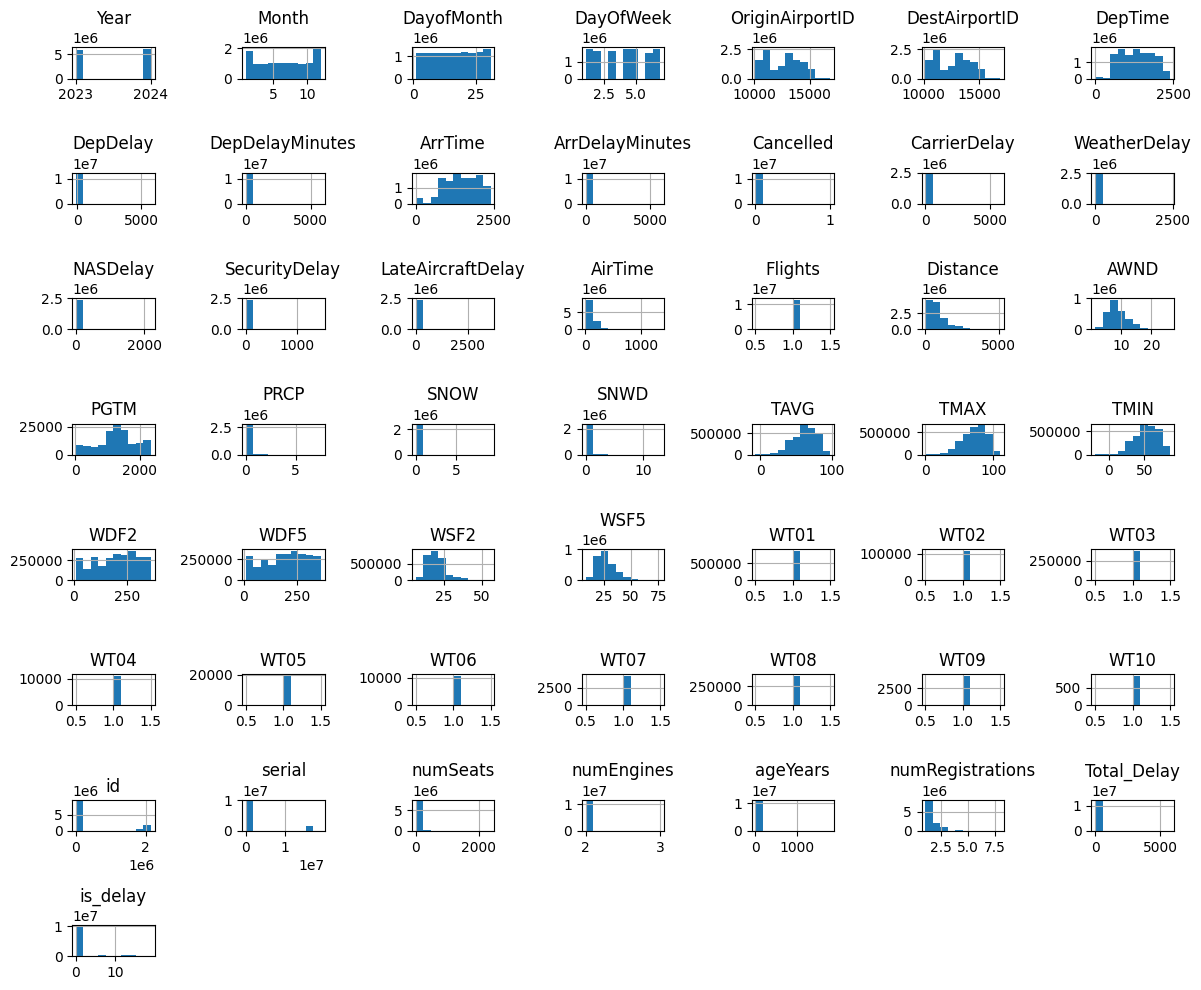

In [16]:
# Plot histograms for all numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns].hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


These graphs show the predominance of on-time flights (with spikes near zero delay), fewer canceled flights, and a relatively wide range in distance and air time. The weather variables show that many days have zero precipitation or snow, with a smaller portion experiencing significant weather events. Aircraft features like seats and engines cluster around typical commercial configurations. By reviewing each subplot, one can quickly identify where most values lie (the tall bars) and how often extreme values occur (the long tails), providing a comprehensive snapshot of the dataset’s structure and any potential anomalies.

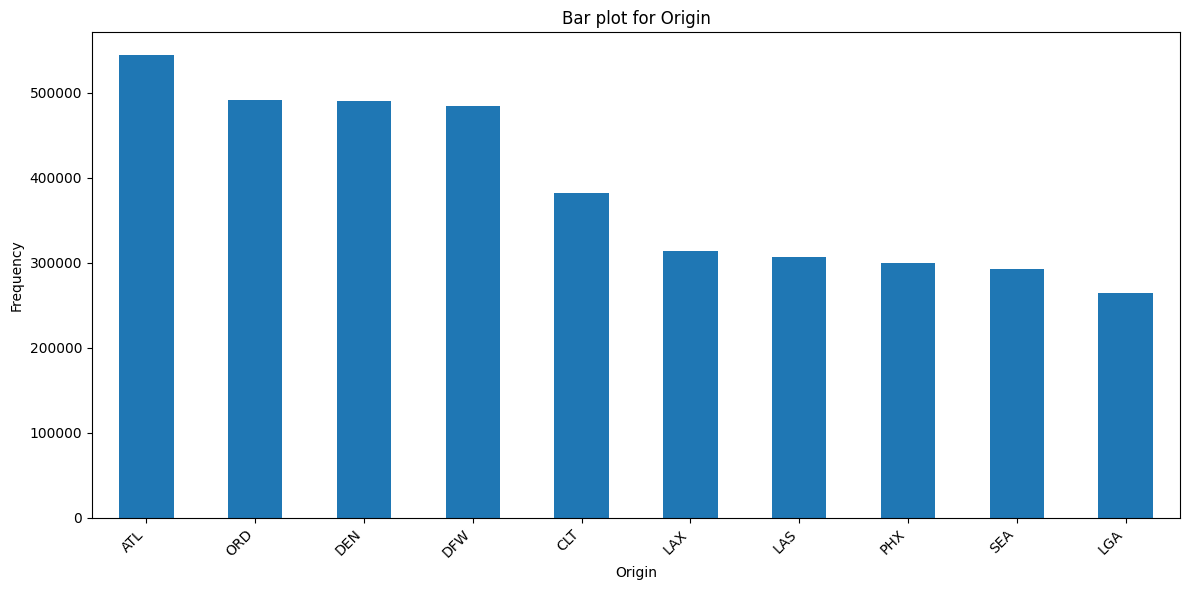

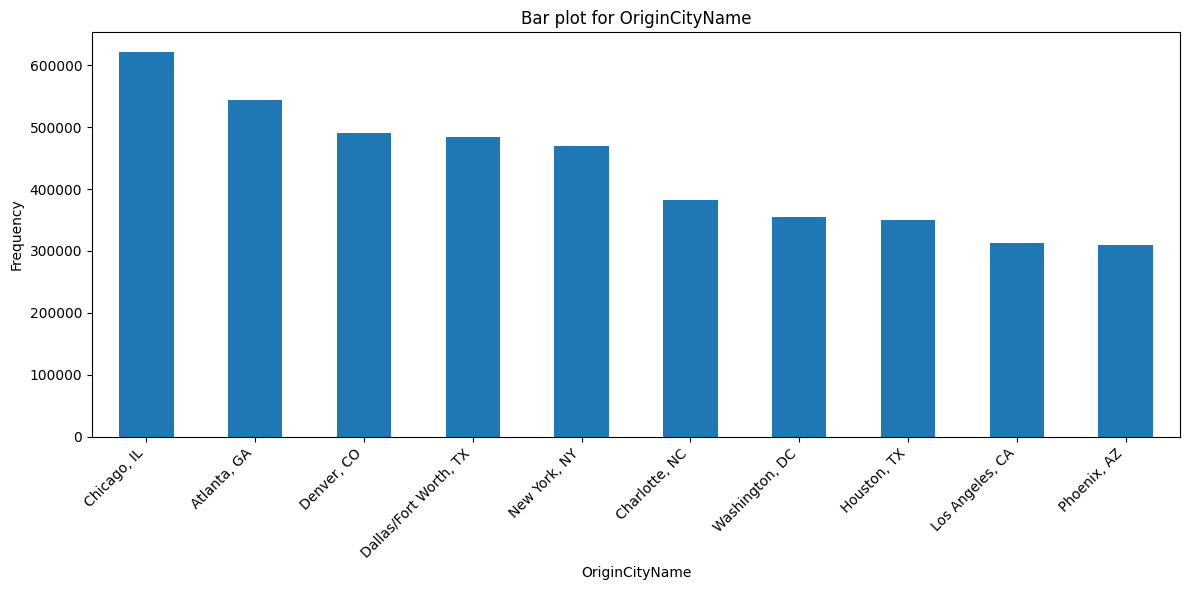

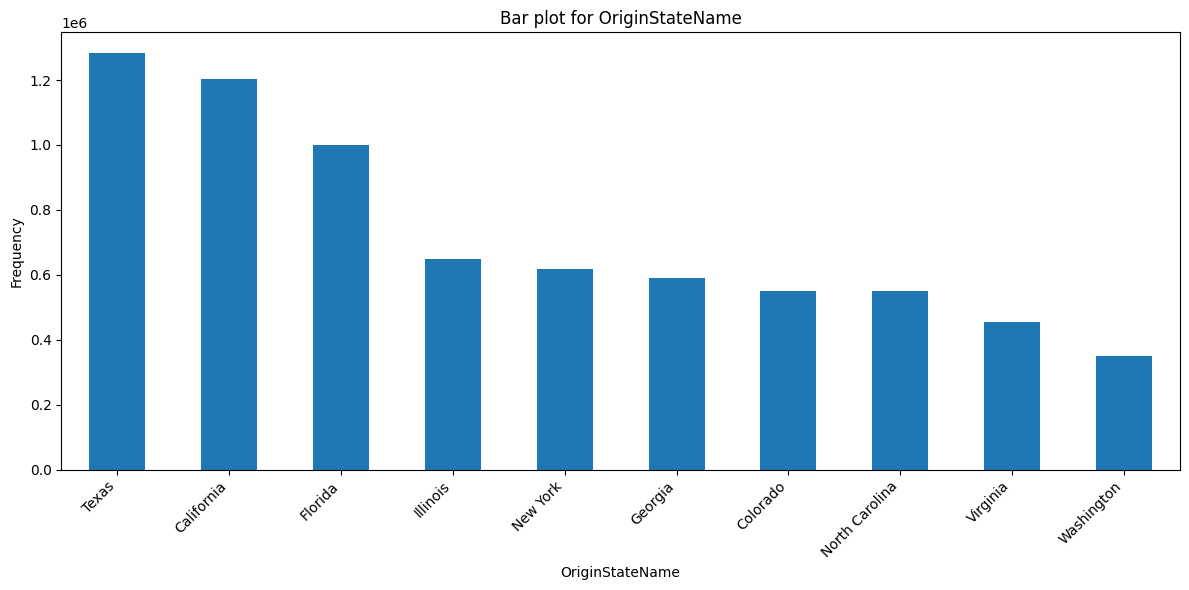

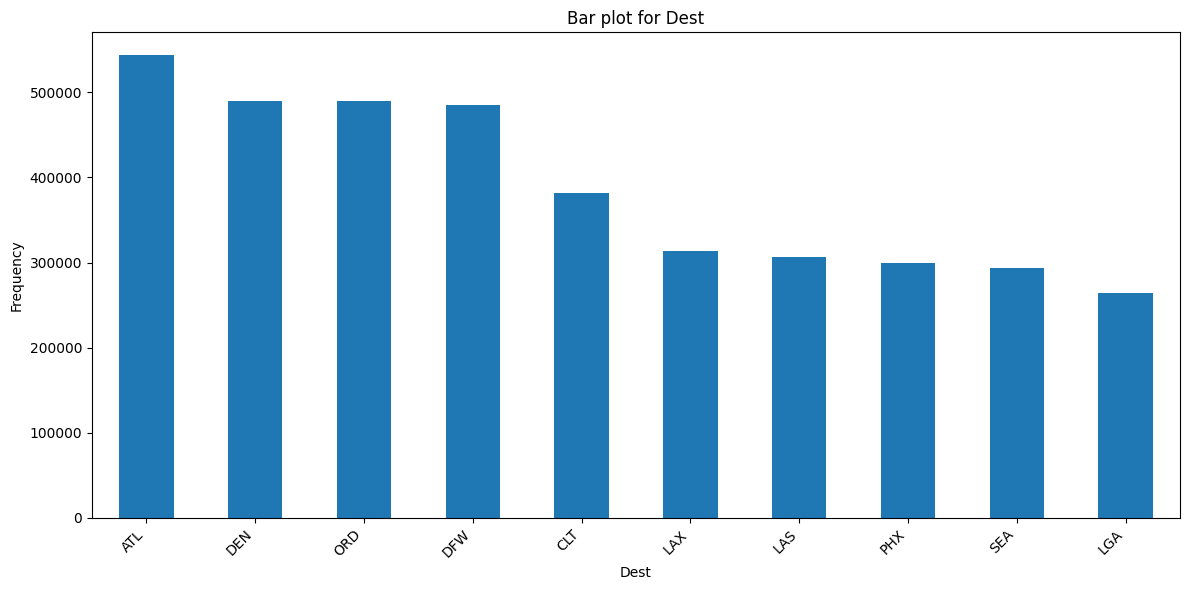

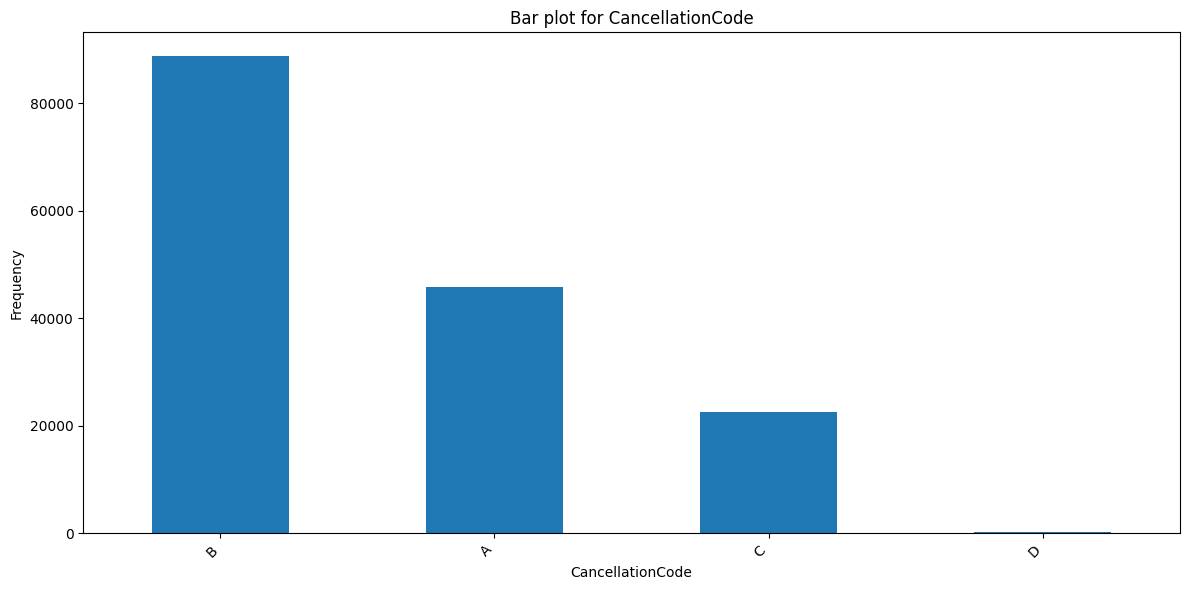

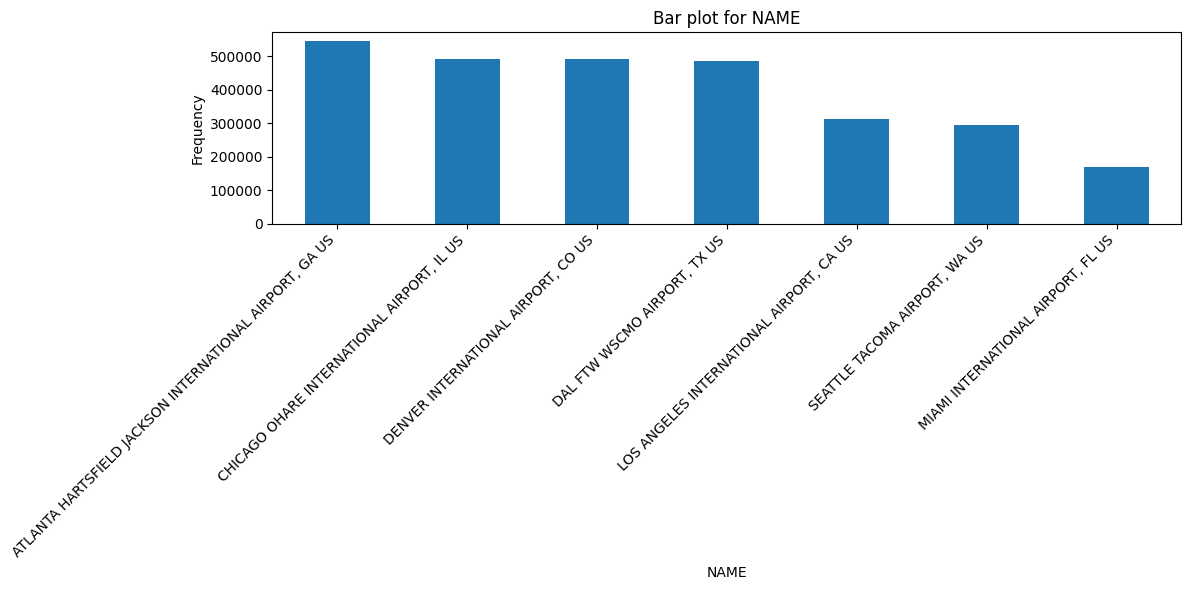

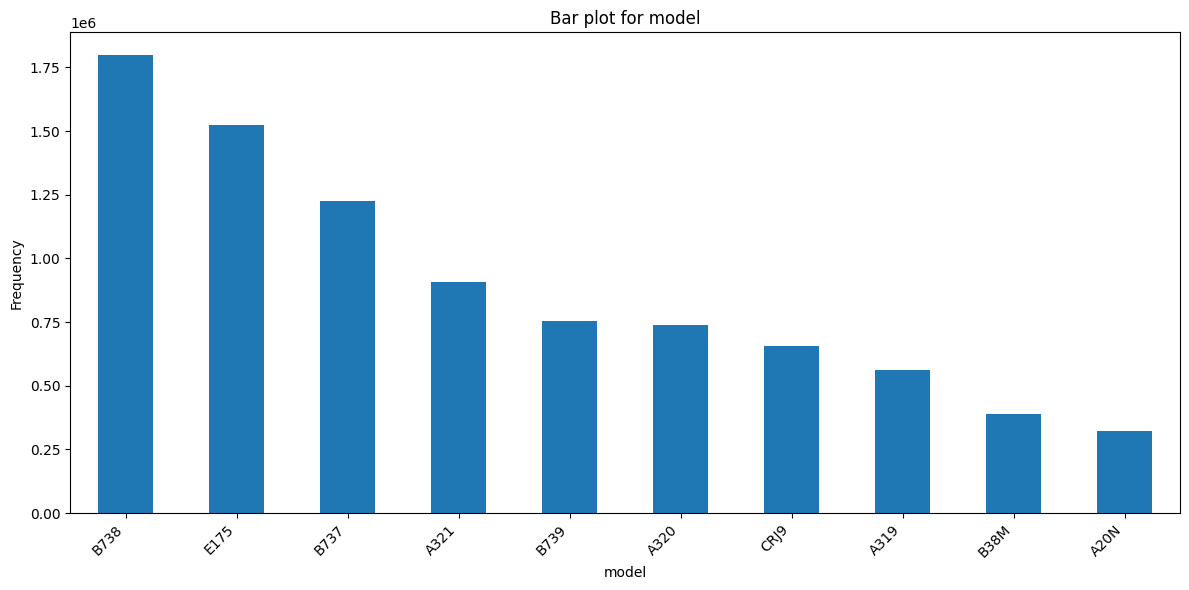

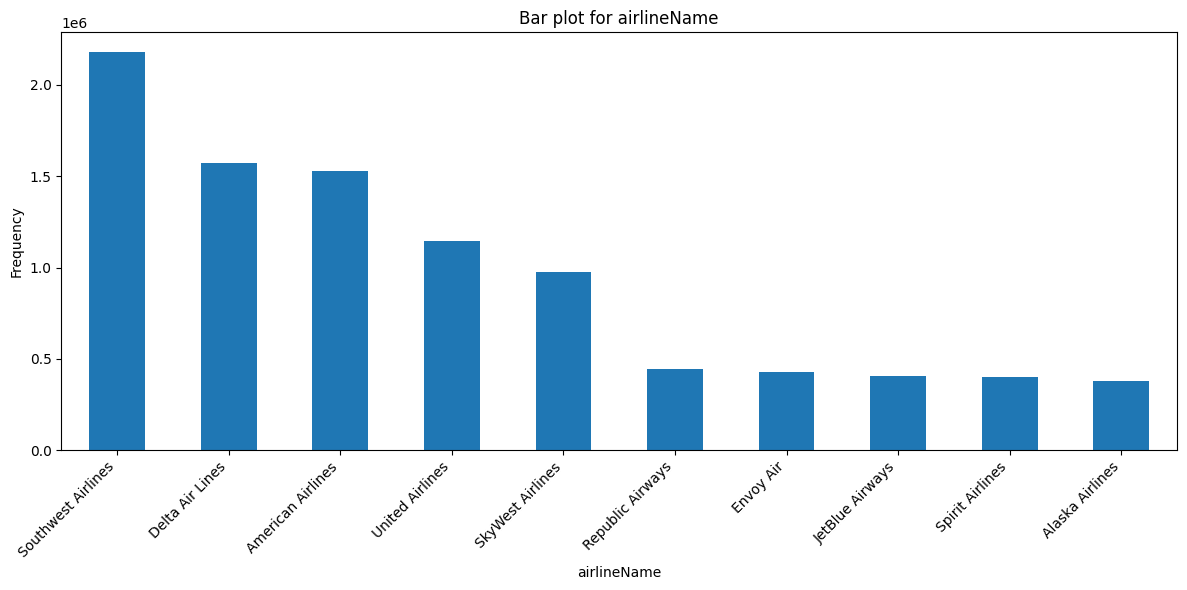

In [17]:
# List of columns to plot bar plots for
columns_to_plot = ['Origin', 'OriginCityName', 'OriginStateName', 'Dest', 'CancellationCode', 'NAME', 'model', 'airlineName']

for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Count the occurrences of each category
    value_counts = data[column].value_counts()
    
    # Limit to top N categories (e.g., top 10)
    top_n = 10
    value_counts = value_counts.head(top_n)
    
    # Plot the bar plot
    value_counts.plot(kind='bar')
    
    # Set the title and labels
    plt.title(f'Bar plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Rotate the x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to make space for labels
    plt.show()



Bar plot for Origin (airport codes)
The dominance of airports like ATL, ORD, and DFW indicates that a handful of major hubs handle a disproportionate share of flights. This concentration suggests these locations serve as key connection points in the domestic network, funneling a large volume of passengers and cargo through their terminals. It also highlights the “hub-and-spoke” model many airlines rely on to aggregate travelers from smaller markets.

⸻

Bar plot for OriginCityName
Seeing large metropolitan areas (e.g., Chicago, Atlanta, Denver) at the top confirms that big cities drive air travel demand. Their central geographic positions or population density make them strategic nodes for airlines. This also underscores the fact that some cities, such as Chicago or Dallas-Fort Worth, may host multiple major airports, further boosting their overall flight counts.

⸻

Bar plot for OriginStateName
States like Texas, California, and Florida lead the pack, reflecting not only their large populations but also their status as major tourist and business destinations. High volumes in places like Illinois and New York reinforce the idea that regions with prominent economic centers and busy airports can dominate flight traffic on a national scale.

⸻

Bar plot for CancellationCode
Weather-related cancellations appear to overshadow other causes. This indicates that operational issues beyond an airline’s direct control (like storms, hurricanes, or winter weather) can disrupt schedules more often than carrier or security factors. It suggests airlines and airports must build contingency plans primarily around mitigating weather impacts to maintain reliability.

⸻

Bar plot for NAME (airport full names)
The most frequent airports by name mirror the major hubs seen in the Origin bar chart, underscoring how a few large airports—often serving both domestic and international routes—act as primary gateways. Airports like Miami or Los Angeles also reflect substantial international traffic, highlighting the role of coastal hubs in connecting the U.S. to global markets.

⸻

Bar plot for model (aircraft type)
The Boeing 737 family’s popularity (especially the 737-800) points to a preference for versatile, single-aisle jets capable of efficiently serving short- to medium-haul routes. Meanwhile, the Embraer 175’s strong showing underlines the large volume of regional operations. The presence of next-generation aircraft (e.g., 737 MAX, A320neo) indicates gradual fleet modernization, though established models still dominate.

⸻

Bar plot for airlineName
Southwest’s lead aligns with its high-frequency, point-to-point network strategy, whereas legacy carriers (Delta, American, United) remain powerhouses due to their extensive hub-and-spoke systems. The notable ranks of regional operators (SkyWest, Republic, Envoy) emphasize that a significant share of flights is operated on behalf of major airlines, especially to smaller airports. Meanwhile, low-cost carriers like Spirit and JetBlue have carved out sizable niches, though they still trail the biggest players in sheer volume.

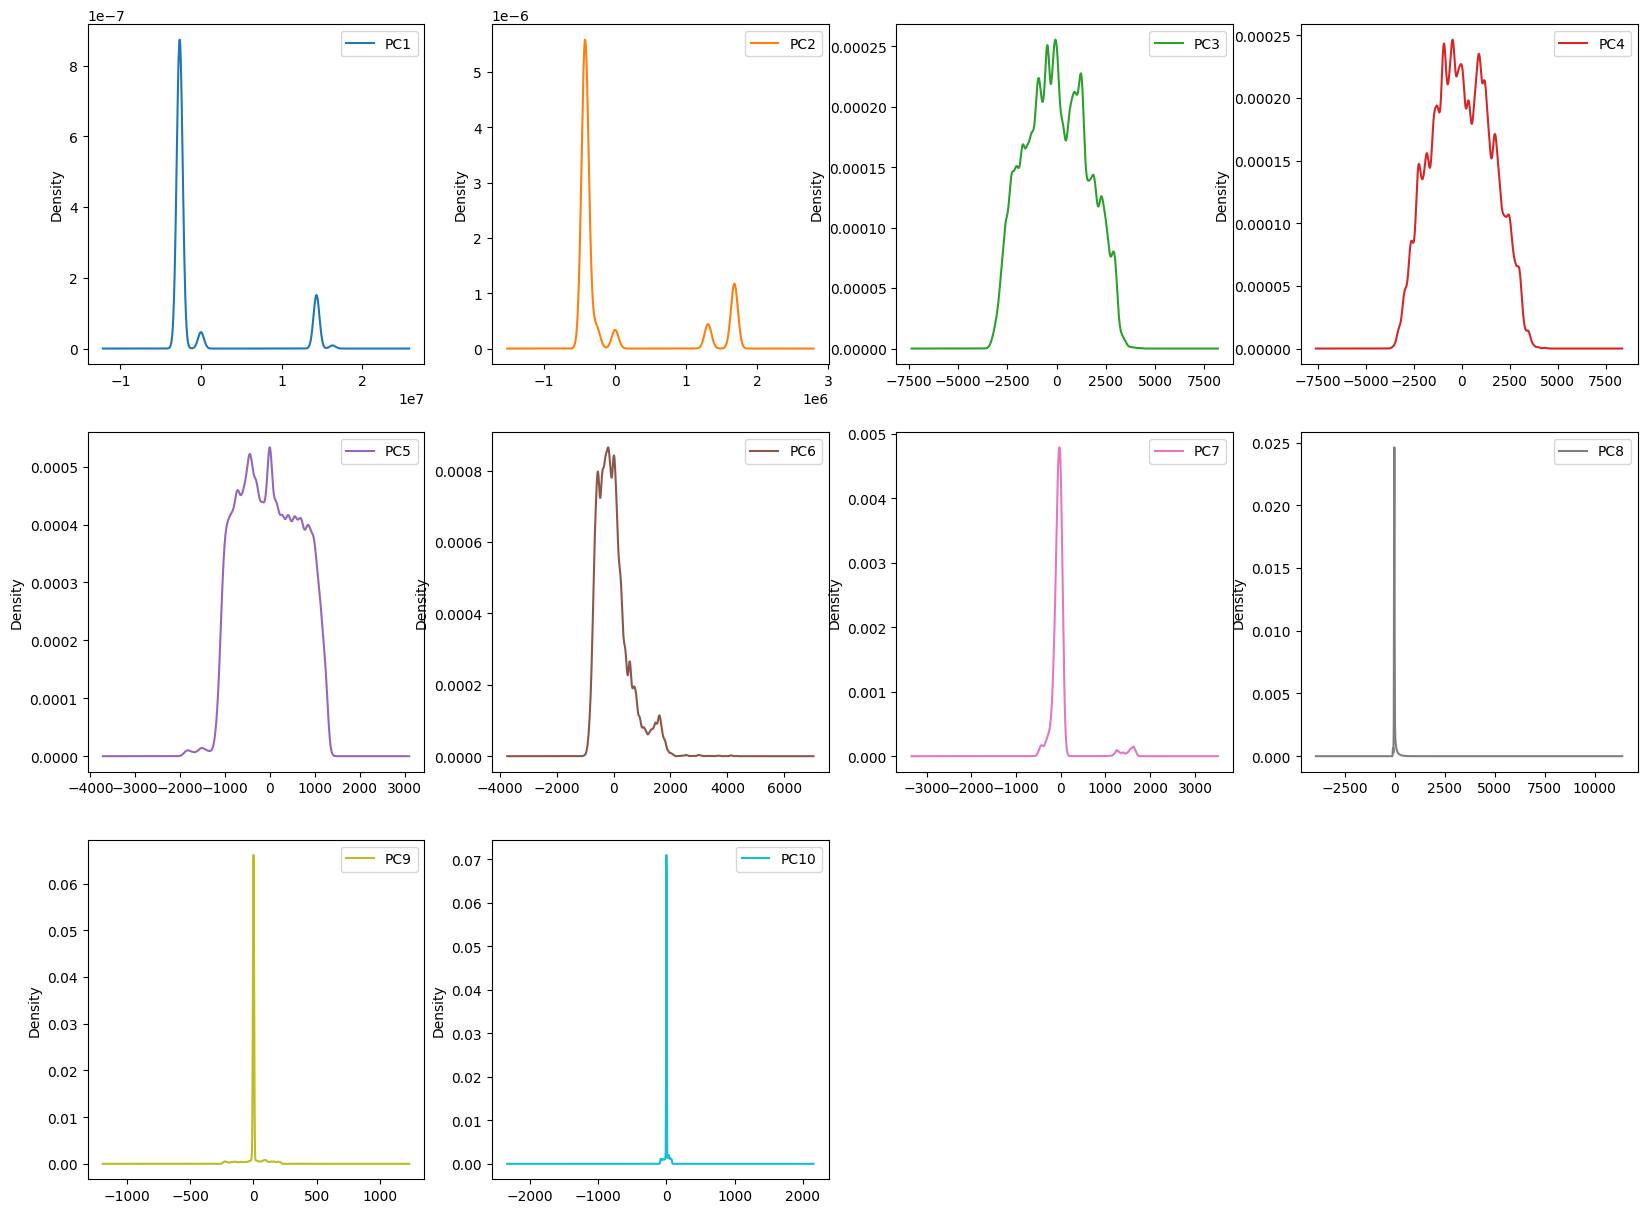

In [18]:
import math
from sklearn.decomposition import PCA

# Sample the data
sampled_data = data.sample(frac=0.1, random_state=42)

# Select numerical columns
numeric_cols = sampled_data.select_dtypes(include=[np.number])

# Handle missing values by filling with the mean of each column
numeric_cols_filled = numeric_cols.fillna(numeric_cols.mean())

# Apply PCA to reduce dimensionality
pca = PCA(n_components=min(len(numeric_cols_filled.columns), 10))  # Reduce to at most 10 dimensions
reduced_data = pca.fit_transform(numeric_cols_filled)

# Convert reduced data back to a DataFrame for plotting
reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])

# Determine the number of subplots needed
num_cols = len(reduced_df.columns)
rows = math.ceil(num_cols / 4)  # Adjust rows dynamically for 4 columns per row

# Plot density plots for all reduced dimensions
reduced_df.plot(kind='density', subplots=True, layout=(rows, 4), sharex=False, figsize=(20, 5 * rows))

plt.show()

In examining these principal component distributions, we see that the first few components (PC1, PC2, PC3, PC4) exhibit broader or more complex shapes, indicating they capture the majority of the dataset’s variance. This broader spread or multiple peaks often reflects distinct subgroups or critical patterns driving the data’s structure. Meanwhile, later components (PC5 through PC10) appear more narrowly clustered around zero, suggesting they capture smaller, more subtle sources of variation or noise. Distributions that are symmetrical around zero point to balanced directions of variation, whereas skewed or long-tailed shapes suggest a few extreme observations or specialized subgroups. Taken together, these patterns highlight how a small number of principal components explain most of the dataset’s variability, while subsequent components account for increasingly fine-grained differences.

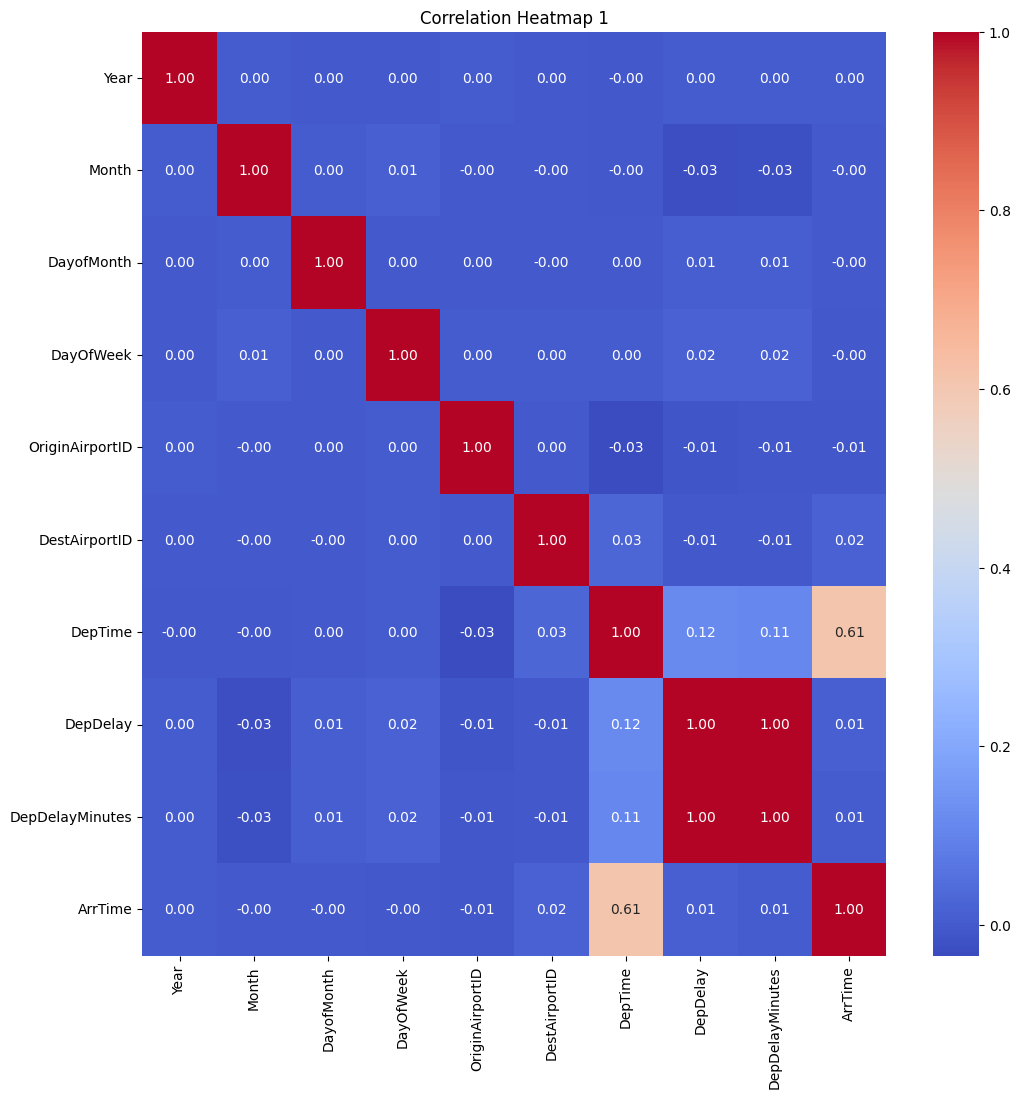

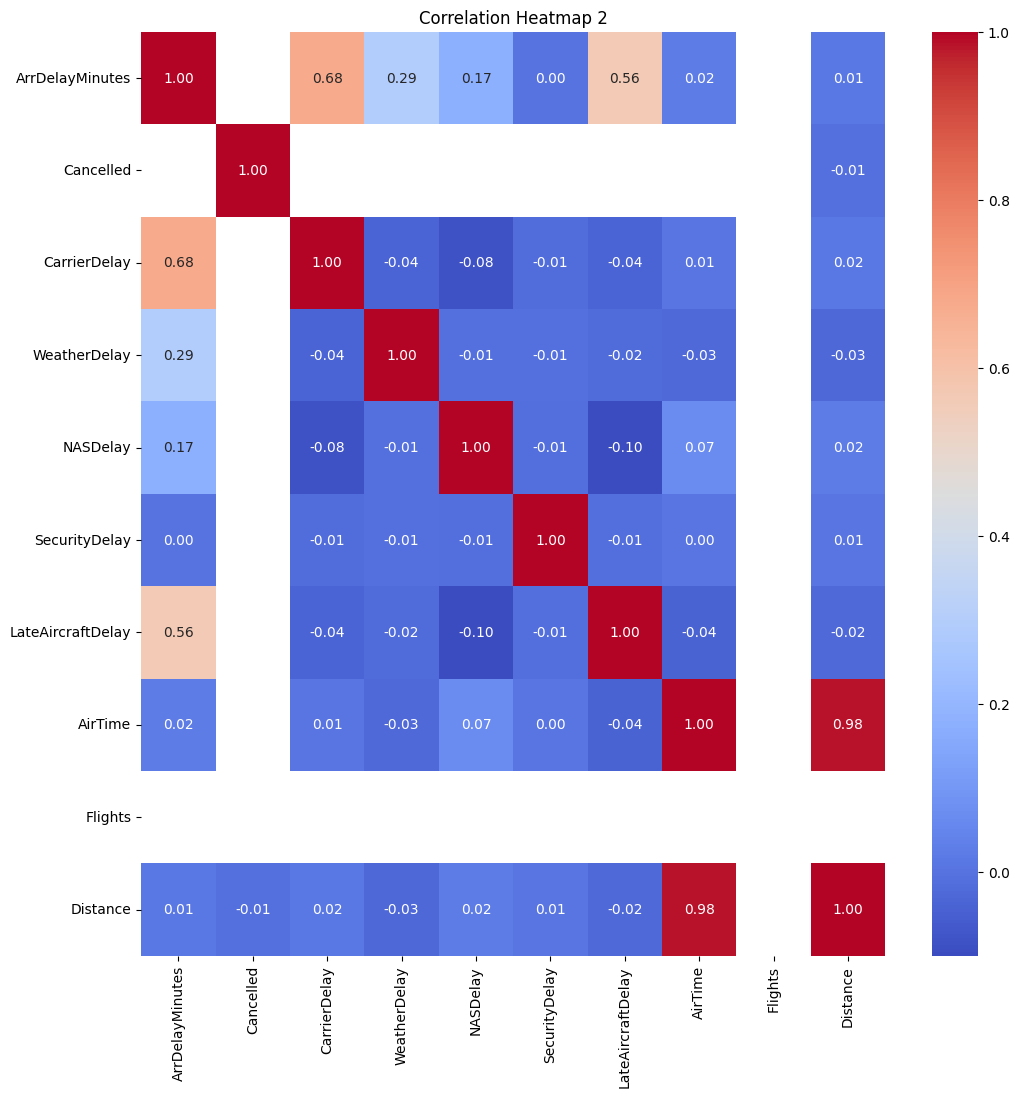

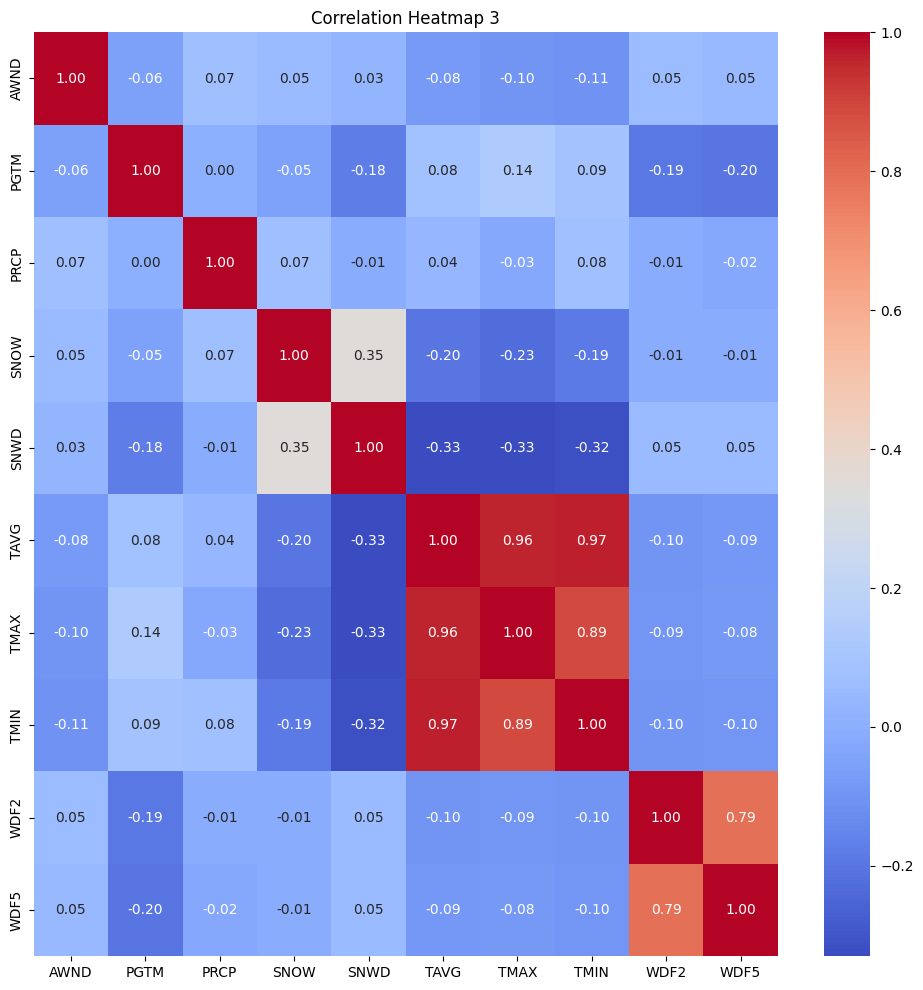

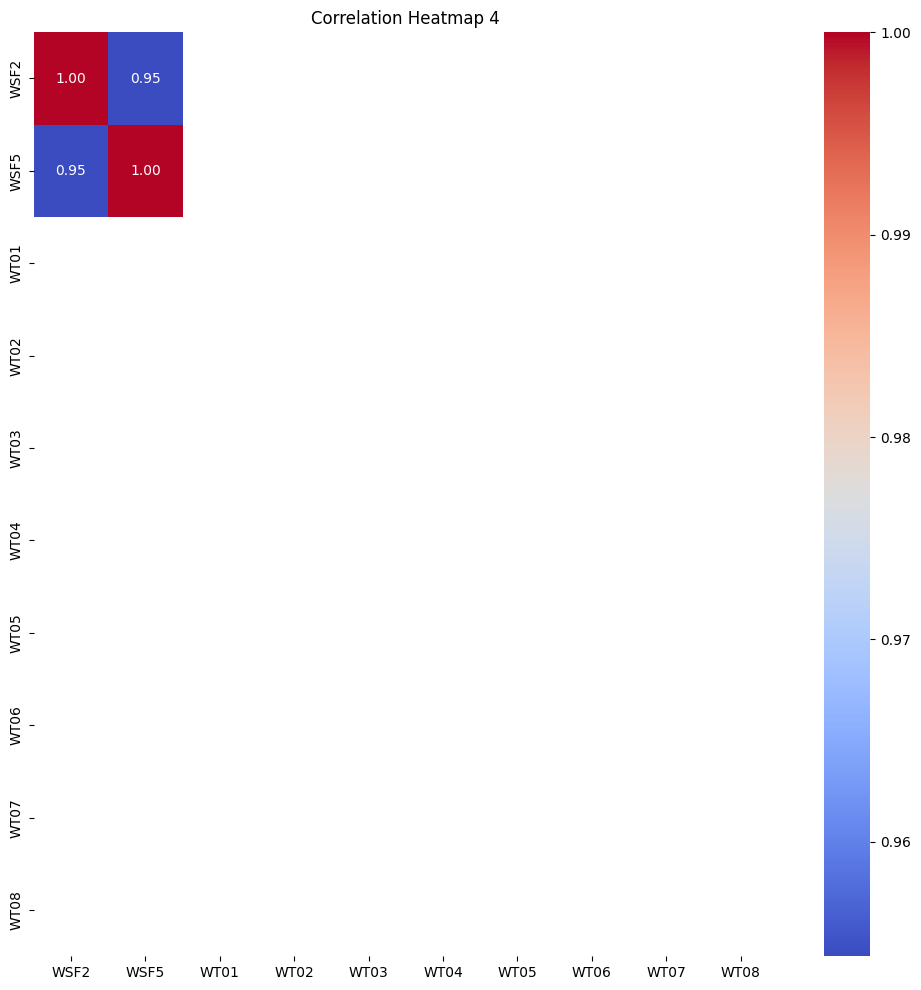

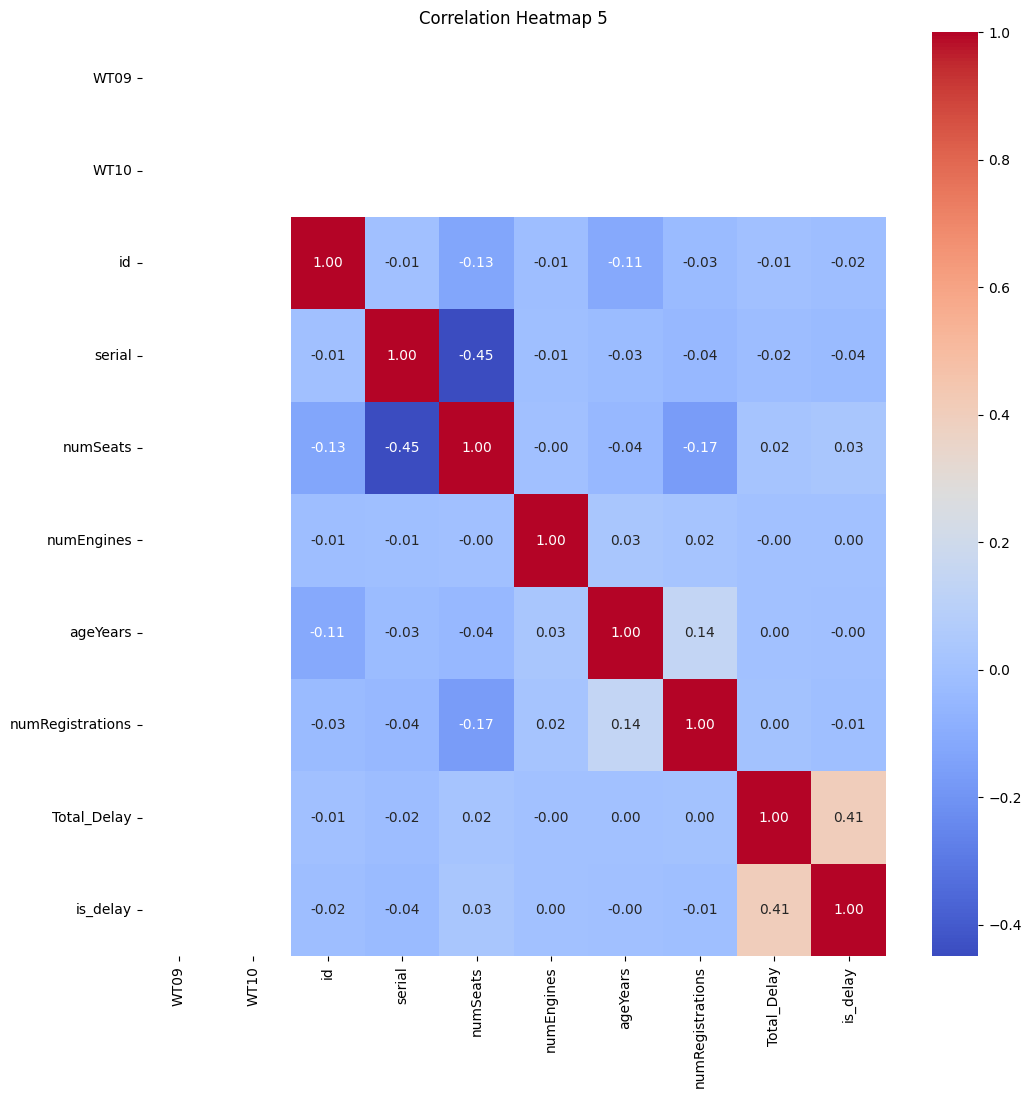

In [19]:
column_groups = [numeric_cols.columns[i:i+10] for i in range(0, len(numeric_cols.columns), 10)]

# Plot correlation heatmaps for each group

for i, cols in enumerate(column_groups):
    plt.figure(figsize=(12, 12))
    sns.heatmap(sampled_data[cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f"Correlation Heatmap {i + 1}")
    plt.show()


In these correlation heatmaps, the first notable pattern is that most date and time fields (e.g., Year, Month, DayOfWeek) are largely uncorrelated with each other, though there is a mild positive relationship between departure time and delays—indicating later flights may experience slightly higher delays. Meanwhile, AirTime and Distance in the second heatmap display a very high correlation, reflecting that longer routes inherently require more flight time. Weather variables show the expected clustering of temperature measures (TAVG, TMAX, TMIN) in the third heatmap, whereas precipitation (PRCP, SNOW) remains more independent from wind- or temperature-related factors. The fourth heatmap highlights a near-perfect correlation between wind speed metrics (WSF2, WSF5), suggesting they capture the same phenomenon in slightly different ways. Finally, the fifth heatmap reveals a moderate correlation between total delay and the binary delay indicator, as well as a hint that certain aircraft attributes (e.g., seat count, engine count) may have weaker but still notable links to how often or how severely flights are delayed.

In [22]:
# For airports - count flights by airport
origin_counts = data['Origin'].value_counts()
dest_counts = data['Dest'].value_counts()

# Get the busiest and least busy airports
busiest_origin = origin_counts.idxmax()
busiest_origin_count = origin_counts.max()
least_busy_origin = origin_counts.idxmin()
least_busy_origin_count = origin_counts.min()

busiest_dest = dest_counts.idxmax()
busiest_dest_count = dest_counts.max()
least_busy_dest = dest_counts.idxmin()
least_busy_dest_count = dest_counts.min()

print("\nAirport Traffic Analysis:")
print(f"Busiest origin airport: {busiest_origin} with {busiest_origin_count} departures")
print(f"Least busy origin airport: {least_busy_origin} with {least_busy_origin_count} departures")
print(f"Busiest destination airport: {busiest_dest} with {busiest_dest_count} arrivals")
print(f"Least busy destination airport: {least_busy_dest} with {least_busy_dest_count} arrivals")


Airport Traffic Analysis:
Busiest origin airport: ATL with 543601 departures
Least busy origin airport: PUB with 24 departures
Busiest destination airport: ATL with 543384 arrivals
Least busy destination airport: PUB with 21 arrivals


In [23]:
# Get total traffic (origins + destinations) for each airport
all_airports = pd.concat([origin_counts, dest_counts], axis=1).fillna(0)
all_airports.columns = ['origin_count', 'dest_count']
all_airports['total_flights'] = all_airports['origin_count'] + all_airports['dest_count']
all_airports = all_airports.sort_values('total_flights', ascending=False)

print("\nTop 5 busiest airports overall:")
print(all_airports.head(5))

print("\nBottom 5 least busy airports overall:")
print(all_airports.tail(5))


Top 5 busiest airports overall:
     origin_count  dest_count  total_flights
ATL        543601      543384        1086985
ORD        490726      489997         980723
DEN        490022      490047         980069
DFW        484157      484783         968940
CLT        382035      381791         763826

Bottom 5 least busy airports overall:
     origin_count  dest_count  total_flights
EAR            90          83            173
OWB            31          37             68
MGW            31          34             65
EAU            24          25             49
PUB            24          21             45


/var/folders/35/1yg39d9115qbxr2wc9pksgjm0000gn/T/ipykernel_20463/2079939150.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DepHour', y='is_delay', data=hourly, ci=None, color='green')


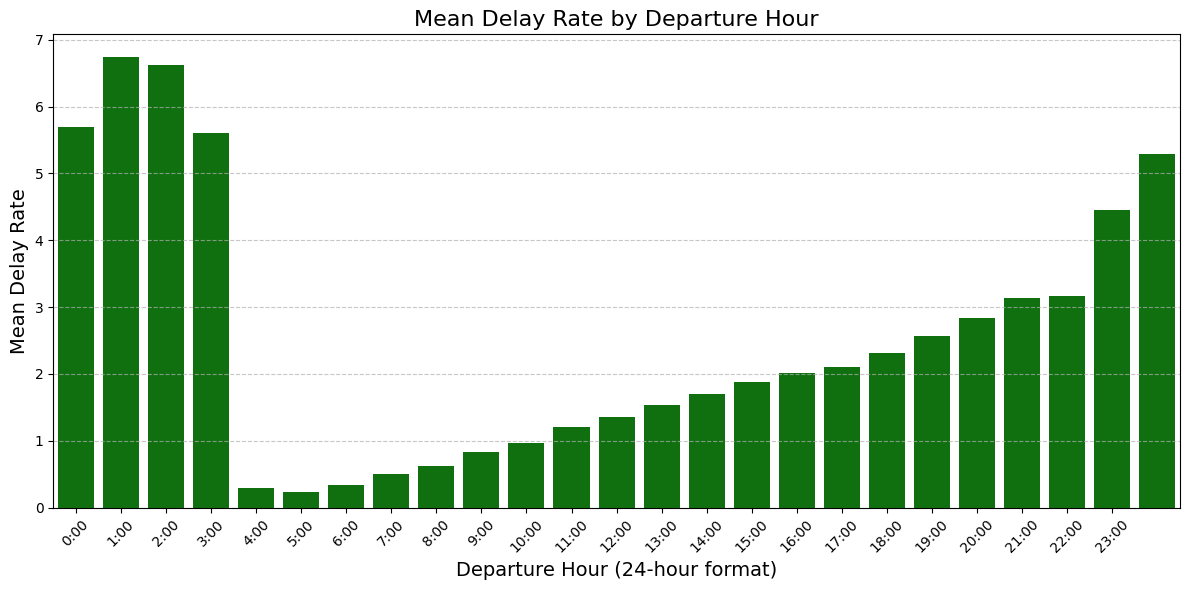

/var/folders/35/1yg39d9115qbxr2wc9pksgjm0000gn/T/ipykernel_20463/2079939150.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DayOfWeek', y='is_delay', data=day_delays, ci=None, color='red')


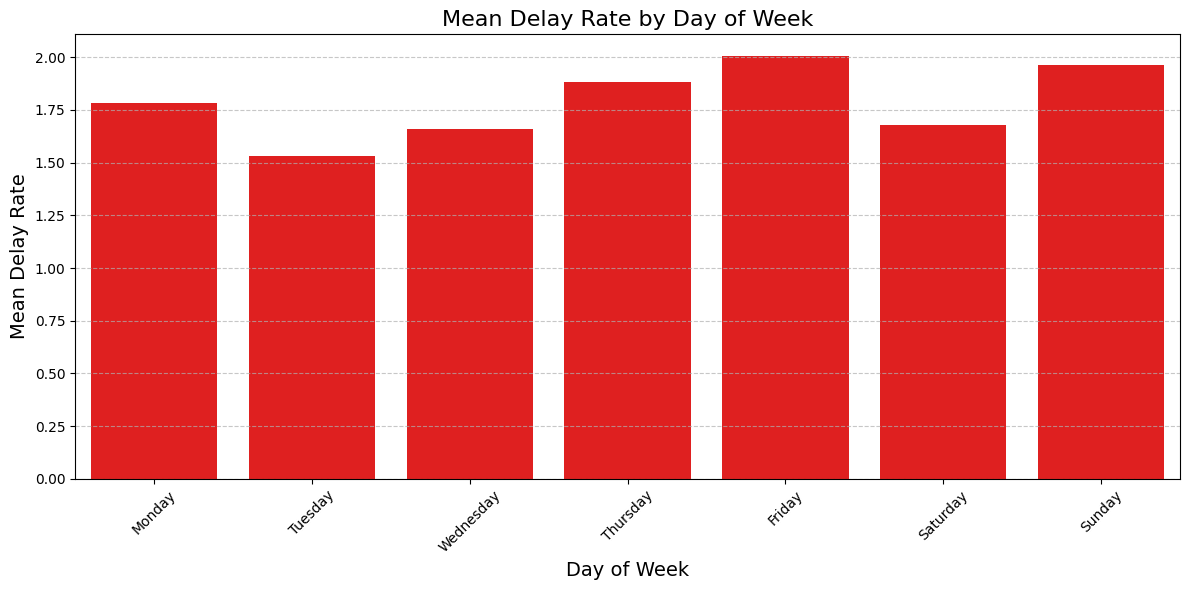

In [24]:
data['DepHour'] = data['DepTime'] // 100

# Plot the mean delay rate by departure hour
hourly = data.groupby('DepHour')['is_delay'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DepHour', y='is_delay', data=hourly, ci=None, color='green')
plt.title('Mean Delay Rate by Departure Hour', fontsize=16)
plt.xlabel('Departure Hour (24-hour format)', fontsize=14)
plt.ylabel('Mean Delay Rate', fontsize=14)
plt.xticks(ticks=range(0, 24), labels=[f"{hour}:00" for hour in range(0, 24)], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot the mean delay rate by day of the week
day_delays = data.groupby('DayOfWeek')['is_delay'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek', y='is_delay', data=day_delays, ci=None, color='red')
plt.title('Mean Delay Rate by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Mean Delay Rate', fontsize=14)
plt.xticks(
    ticks=range(7),
    labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    rotation=45
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From this chart, we can see that very late-night and early-morning departures (around 1:00–4:00) tend to have relatively high delay rates, likely reflecting accumulated disruptions from the previous day or rescheduled red-eye flights. As the morning progresses, delay rates drop significantly—airlines typically start the day with on-time departures because aircraft and crews are positioned overnight. Then, as the afternoon and evening hours set in, delays gradually climb again, suggesting that small schedule slippages build up throughout the day. This pattern underscores how operational challenges earlier in the schedule can ripple forward, resulting in higher average delays later on.

Delays appear to be lowest mid-week, with Wednesday showing the most punctual performance, while Friday and Sunday see higher average delay rates. This pattern suggests that heavier travel volumes around the weekend can strain resources and lead to more frequent or longer disruptions. Meanwhile, mid-week days may benefit from steadier traffic flows, resulting in fewer cumulative scheduling issues. Overall, the weekend surge in passenger demand—and the potential knock-on effects of weather or staffing—likely contributes to the spike in delays toward the end of the week and on Sundays.

# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

1. Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns

    - Fill in missing values with median
    - Drop WT01 - WT10 columns
    - Drop PGTM column

2. Feature selection (optional): Drop attributes that provide no useful information for the task

3. Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features\

    - Create a seasons feature
    - Create a isWeekend feature
    - Create a quarter feature

4. Feature scaling: standardize or normalize features

In [13]:
# Drop the 'is_delay' column (use errors='ignore' to avoid errors if the column doesn't exist)
trainDataWithoutTarget = data.drop(columns=["is_delay"], errors="ignore")

# Save the Data to a parquet file
trainDataWithoutTarget.to_parquet('train_set_wo_target.parquet')



In [4]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
import gc
import psutil
import time
import os
import warnings
warnings.filterwarnings('ignore')

class FeatureNameMaintainer(BaseEstimator, TransformerMixin):
    """Transformer that preserves feature names throughout the pipeline"""
    
    def __init__(self):
        self.feature_names = None
        
    def fit(self, X, y=None):
        # Store the feature names during fit
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        return self
        
    def transform(self, X, y=None):
        # Ensure output is a DataFrame with proper column names
        if isinstance(X, np.ndarray) and self.feature_names is not None:
            # If dimensions match, use stored feature names
            if X.shape[1] == len(self.feature_names):
                return pd.DataFrame(X, columns=self.feature_names)
            else:
                # This indicates something changed in the pipeline
                return pd.DataFrame(X)
        elif isinstance(X, pd.DataFrame):
            return X
        else:
            return pd.DataFrame(X)

# Memory monitoring function
def log_memory_usage(checkpoint_name):
    # Force garbage collection
    gc.collect()
    
    # Get current process
    process = psutil.Process()
    
    # Get memory info in GB
    memory_info = process.memory_info()
    memory_usage = memory_info.rss / (1024 * 1024 * 1024)  # Convert to GB
    
    print(f"Checkpoint: {checkpoint_name} | Memory Usage: {memory_usage:.2f} GB | Time: {time.strftime('%H:%M:%S')}")
    
    return memory_usage

# Custom transformers with improved timestamp handling
class SafeTransformer(BaseEstimator, TransformerMixin):
    """Base class that ensures all datetime columns are converted to numeric"""
    
    def _convert_datetime_columns(self, X):
        """Convert any datetime columns to float timestamps"""
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                if pd.api.types.is_datetime64_any_dtype(X[col]):
                    X[col] = X[col].astype(np.int64) / 10**9
        return X

class MissingMedianTransformer(SafeTransformer):
    """
    Fill missing values with the median for numeric columns.
    """
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        log_memory_usage("Start MissingMedianTransformer fit")
        # Convert datetime columns first
        X = self._convert_datetime_columns(X)
        
        if self.columns is None:
            self.columns = X.select_dtypes(include=[np.number]).columns
        # Store medians in a dictionary instead of a Series to reduce memory
        self.medians_ = {}
        for col in self.columns:
            if col in X.columns:  # Only process columns that exist
                self.medians_[col] = X[col].median()
                # Free memory after each column calculation
                gc.collect()
        log_memory_usage("End MissingMedianTransformer fit")
        return self
        
    def transform(self, X, y=None):
        log_memory_usage("Start MissingMedianTransformer transform")
        X_transformed = X.copy()
        
        # Convert datetime columns first
        X_transformed = self._convert_datetime_columns(X_transformed)
        
        # Process columns in batches to reduce peak memory
        for i, col in enumerate(self.columns):
            if col in X_transformed.columns:  # Only process columns that exist
                X_transformed[col] = X_transformed[col].fillna(self.medians_[col])
                if i % 10 == 0:  # Log every 10 columns
                    gc.collect()
        log_memory_usage("End MissingMedianTransformer transform")
        return X_transformed

class DropColumnsTransformer(SafeTransformer):
    """
    Drop specified columns.
    """
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        log_memory_usage("Start DropColumnsTransformer transform")
        X_transformed = X.copy()
        
        # Convert datetime columns first
        X_transformed = self._convert_datetime_columns(X_transformed)
        
        result = X_transformed.drop(columns=self.columns, errors='ignore')
        log_memory_usage("End DropColumnsTransformer transform")
        return result

class DateHandler(SafeTransformer):
    """
    Comprehensive date handler that extracts features and converts any datetime columns.
    """
    def __init__(self, date_column='FlightDate'):
        self.date_column = date_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        log_memory_usage("Start DateHandler transform")
        X_transformed = X.copy()
        
        # First, convert all datetime columns to datetime type
        for col in X_transformed.columns:
            if pd.api.types.is_datetime64_any_dtype(X_transformed[col]) or (
                    pd.api.types.is_object_dtype(X_transformed[col]) and 
                    X_transformed[col].dtypes == 'object'):
                try:
                    X_transformed[col] = pd.to_datetime(X_transformed[col], errors='coerce')
                except:
                    # If conversion fails, we'll handle this column differently
                    continue
        
        # Extract features from the main date column if it exists
        if self.date_column in X_transformed.columns:
            try:
                # Convert to datetime if not already
                X_transformed[self.date_column] = pd.to_datetime(X_transformed[self.date_column], errors='coerce')
                
                # Extract features
                X_transformed['Year'] = X_transformed[self.date_column].dt.year
                X_transformed['Month'] = X_transformed[self.date_column].dt.month
                X_transformed['Day'] = X_transformed[self.date_column].dt.day
                X_transformed['DayOfWeek'] = X_transformed[self.date_column].dt.dayofweek + 1
                X_transformed['Quarter'] = X_transformed[self.date_column].dt.quarter
                
                # Create season feature
                season_map = {
                    1: 'Winter', 2: 'Winter', 12: 'Winter',
                    3: 'Spring', 4: 'Spring', 5: 'Spring',
                    6: 'Summer', 7: 'Summer', 8: 'Summer',
                    9: 'Fall', 10: 'Fall', 11: 'Fall'
                }
                X_transformed['Season'] = X_transformed[self.date_column].dt.month.map(season_map)
                
                # Create weekend feature if DayOfWeek is available
                X_transformed['isWeekend'] = np.where(X_transformed['DayOfWeek'].isin([6, 7]), 1, 0)
                
                # Drop the original date column
                X_transformed = X_transformed.drop(columns=[self.date_column])
            except Exception as e:
                print(f"Error processing date column {self.date_column}: {e}")
                # Keep moving even if we can't process the main date column
        
        # Convert ANY remaining datetime columns to numeric timestamps
        X_transformed = self._convert_datetime_columns(X_transformed)
        
        log_memory_usage("End DateHandler transform")
        return X_transformed

class NamedColumnTransformer(ColumnTransformer):
    """
    Extension of ColumnTransformer that preserves feature names after transformation.
    """
    def __init__(self, transformers, remainder='drop', sparse_threshold=0.3,
                 n_jobs=None, transformer_weights=None, verbose=False,
                 verbose_feature_names_out=True):
        super().__init__(
            transformers=transformers,
            remainder=remainder,
            sparse_threshold=sparse_threshold,
            n_jobs=n_jobs,
            transformer_weights=transformer_weights,
            verbose=verbose,
            verbose_feature_names_out=verbose_feature_names_out
        )
        
    def transform(self, X):
        # Call the parent transform method
        result = super().transform(X)
        
        # Get the feature names using the get_feature_names_out method
        feature_names = self.get_feature_names_out()
        
        # Convert to DataFrame with feature names
        return pd.DataFrame(result, columns=feature_names, index=X.index if hasattr(X, 'index') else None)

def process_parquet_in_chunks(parquet_file, pipeline, chunk_size=1000, save_path=None):
    """
    Process a large Parquet file in chunks to manage memory usage.
    Uses manual chunk reading since pandas doesn't support chunksize for parquet.
    
    Parameters:
    -----------
    parquet_file : str
        Path to the Parquet file containing the data.
    pipeline : Pipeline
        Scikit-learn pipeline to use for processing.
    chunk_size : int, default=1000
        Number of rows in each chunk.
    save_path : str, optional
        If provided, processed chunks will be saved to this path.
        
    Returns:
    --------
    None or DataFrame
        If save_path is provided, returns None; otherwise returns the processed DataFrame.
    """
    log_memory_usage(f"Starting Parquet processing with chunk_size={chunk_size}")
    
    # Get file info first
    log_memory_usage("Reading metadata")
    try:
        # Get a small sample just to examine the file
        sample_df = pd.read_parquet(parquet_file, engine='pyarrow').head(10)
        print("Column info:")
        for col in sample_df.columns:
            print(f"  {col}: {sample_df[col].dtype}")
            
        # For datetime columns specifically check
        date_cols = [col for col in sample_df.columns 
                     if pd.api.types.is_datetime64_any_dtype(sample_df[col])]
        if date_cols:
            print(f"Date columns found: {date_cols}")
    except Exception as e:
        print(f"Error examining data: {e}")
    
    # Get total number of rows to determine number of chunks
    try:
        import pyarrow.parquet as pq
        file_metadata = pq.read_metadata(parquet_file)
        total_rows = file_metadata.num_rows
        print(f"Total rows in parquet file: {total_rows}")
    except Exception as e:
        print(f"Error with PyArrow: {e}")
        # Fallback method if PyArrow is not installed or fails
        print("Using pandas to get row count")
        total_rows = pd.read_parquet(parquet_file, columns=[]).shape[0]
    
    log_memory_usage(f"Parquet file has {total_rows} rows")
    
    # Create temporary directory for chunks if saving
    if save_path and save_path.endswith('.parquet'):
        temp_dir = save_path.replace('.parquet', '_chunks')
        os.makedirs(temp_dir, exist_ok=True)
    
    # Read the first chunk to fit the pipeline
    fit_chunk_size = min(chunk_size, 10000)  # Use a smaller size for fitting
    
    try:
        log_memory_usage("Reading first chunk for fitting")
        first_chunk = pd.read_parquet(parquet_file, engine='pyarrow').iloc[:fit_chunk_size].copy()
        log_memory_usage(f"Loaded first chunk with {len(first_chunk)} rows")
        
        # Convert all datetime columns to numeric for first chunk
        for col in first_chunk.columns:
            if pd.api.types.is_datetime64_any_dtype(first_chunk[col]):
                print(f"Converting datetime column '{col}' to numeric for fitting")
                first_chunk[col] = pd.to_datetime(first_chunk[col]).astype(np.int64) / 10**9
        
        # Also try to convert string columns that might contain dates
        for col in first_chunk.columns:
            if first_chunk[col].dtype == 'object':
                try:
                    # Try to convert to datetime first
                    datetime_col = pd.to_datetime(first_chunk[col], errors='coerce')
                    # If most values were successfully converted, use the numeric version
                    if datetime_col.notna().mean() > 0.5:  # If more than 50% converted successfully
                        print(f"Converting string column '{col}' to datetime then numeric")
                        first_chunk[col] = datetime_col.astype(np.int64) / 10**9
                except:
                    pass  # Leave as is if conversion fails
        
        # Fit the pipeline on the first chunk
        print("Fitting pipeline on first chunk...")
        pipeline.fit(first_chunk)
        log_memory_usage("Pipeline fitted on first chunk")
        
        # Delete the first chunk to free memory
        del first_chunk
        gc.collect()
        
        # Process the data in chunks
        num_chunks = (total_rows + chunk_size - 1) // chunk_size  # Ceiling division
        
        if save_path:
            # If save path is provided, process and save chunks incrementally
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_size
                end_idx = min((chunk_idx + 1) * chunk_size, total_rows)
                
                log_memory_usage(f"Processing chunk {chunk_idx+1}/{num_chunks} (rows {start_idx}-{end_idx-1})")
                
                # Read chunk
                try:
                    chunk = pd.read_parquet(
                        parquet_file,
                        engine='pyarrow'
                    ).iloc[start_idx:end_idx].copy()
                    
                    log_memory_usage(f"Loaded chunk with {len(chunk)} rows")
                    
                    # Pre-process the chunk to avoid datetime issues
                    # Convert all datetime columns to numeric
                    for col in chunk.columns:
                        if pd.api.types.is_datetime64_any_dtype(chunk[col]):
                            chunk[col] = pd.to_datetime(chunk[col]).astype(np.int64) / 10**9
                    
                    # Transform the chunk
                    processed_chunk = pipeline.transform(chunk)
                    log_memory_usage(f"Transformed chunk {chunk_idx+1}/{num_chunks}")
                    
                    # Ensure processed_chunk is a DataFrame with column names
                    if not isinstance(processed_chunk, pd.DataFrame):
                        try:
                            # Try to get feature names from the pipeline
                            if hasattr(pipeline, 'get_feature_names_out'):
                                feature_names = pipeline.get_feature_names_out()
                                processed_chunk = pd.DataFrame(processed_chunk, columns=feature_names)
                            else:
                                processed_chunk = pd.DataFrame(processed_chunk)
                        except:
                            # Fallback to generic names
                            processed_chunk = pd.DataFrame(processed_chunk)
                    
                    # Save the processed chunk
                    if save_path.endswith('.parquet'):
                        # For parquet, save as separate files and combine later
                        chunk_path = f"{temp_dir}/chunk_{chunk_idx}.parquet"
                        processed_chunk.to_parquet(chunk_path, engine='pyarrow')
                    else:
                        # For CSV, we can append
                        mode = 'w' if chunk_idx == 0 else 'a'
                        header = chunk_idx == 0
                        processed_chunk.to_csv(save_path, mode=mode, header=header, index=False)
                    
                    log_memory_usage(f"Saved chunk {chunk_idx+1}/{num_chunks}")
                    
                except Exception as e:
                    print(f"Error processing chunk {chunk_idx+1}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
                
                # Clean up to free memory
                try:
                    del chunk, processed_chunk
                    gc.collect()
                except:
                    pass
                
            # If we saved as parquet chunks, combine them
            if save_path.endswith('.parquet') and os.path.exists(temp_dir):
                log_memory_usage("Combining parquet chunks")
                
                # List all chunk files
                chunk_files = sorted([os.path.join(temp_dir, f) for f in os.listdir(temp_dir) 
                                    if f.startswith('chunk_') and f.endswith('.parquet')])
                
                if chunk_files:
                    try:
                        # Read the first chunk to get schema
                        combined_df = pd.read_parquet(chunk_files[0])
                        
                        # Append other chunks one by one to avoid memory issues
                        for i, chunk_file in enumerate(chunk_files[1:], 1):
                            log_memory_usage(f"Combining chunk {i}/{len(chunk_files)-1}")
                            try:
                                chunk_df = pd.read_parquet(chunk_file)
                                combined_df = pd.concat([combined_df, chunk_df], ignore_index=True)
                                del chunk_df
                                gc.collect()
                            except Exception as e:
                                print(f"Error combining chunk {i}: {e}")
                        
                        # Save the combined DataFrame
                        log_memory_usage("Saving final combined parquet file")
                        combined_df.to_parquet(save_path, engine='pyarrow')
                        del combined_df
                        gc.collect()
                    except Exception as e:
                        print(f"Error in final combination: {e}")
                        import traceback
                        traceback.print_exc()
                        
                        # If combination fails, at least keep the chunk files
                        print(f"Individual chunks are still available in {temp_dir}/")
                        return None
                    
                    # Clean up temp files
                    log_memory_usage("Cleaning up temporary files")
                    for chunk_file in chunk_files:
                        try:
                            os.remove(chunk_file)
                        except:
                            pass
                    try:
                        os.rmdir(temp_dir)
                    except:
                        pass
                
            print(f"All chunks processed and saved to {save_path}")
            return None
        else:
            # If no save path is provided, store processed chunks in memory and combine at the end
            processed_chunks = []
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_size
                end_idx = min((chunk_idx + 1) * chunk_size, total_rows)
                
                log_memory_usage(f"Processing chunk {chunk_idx+1}/{num_chunks} (rows {start_idx}-{end_idx-1})")
                
                # Read chunk
                try:
                    chunk = pd.read_parquet(
                        parquet_file,
                        engine='pyarrow'
                    ).iloc[start_idx:end_idx].copy()
                    
                    log_memory_usage(f"Loaded chunk with {len(chunk)} rows")
                    
                    # Pre-process the chunk to avoid datetime issues
                    # Convert all datetime columns to numeric
                    for col in chunk.columns:
                        if pd.api.types.is_datetime64_any_dtype(chunk[col]):
                            chunk[col] = pd.to_datetime(chunk[col]).astype(np.int64) / 10**9
                    
                    # Transform the chunk
                    processed_chunk = pipeline.transform(chunk)
                    log_memory_usage(f"Transformed chunk {chunk_idx+1}/{num_chunks}")
                    
                    # Ensure processed_chunk is a DataFrame with column names
                    if not isinstance(processed_chunk, pd.DataFrame):
                        try:
                            # Try to get feature names from the pipeline
                            if hasattr(pipeline, 'get_feature_names_out'):
                                feature_names = pipeline.get_feature_names_out()
                                processed_chunk = pd.DataFrame(processed_chunk, columns=feature_names)
                            else:
                                processed_chunk = pd.DataFrame(processed_chunk)
                        except:
                            # Fallback to generic names
                            processed_chunk = pd.DataFrame(processed_chunk)
                    
                    processed_chunks.append(processed_chunk)
                except Exception as e:
                    print(f"Error processing chunk {chunk_idx+1}: {e}")
                    continue
                
                # Clean up to free memory
                del chunk
                gc.collect()
            
            # Combine all processed chunks
            log_memory_usage("Combining all processed chunks")
            result = pd.concat(processed_chunks, ignore_index=True)
            log_memory_usage("All chunks combined")
            
            # Clean up to free memory
            del processed_chunks
            gc.collect()
            
            return result
    
    except Exception as e:
        print(f"Critical error in processing: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Define columns to drop (UPDATED LIST)
    drop_cols = [
        'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'PGTM',
        'is_delay', 'ArrDelayMinutes', 'Total_Delay', 'LateAircraftDelay', 'DepDelay',
        'CarrierDelay', 'DepDelayMinutes', 'NASDelay', 'DepTime', 'ArrTime', 'Cancelled', 'AirTime', 'WeatherDelay', 'DepHour', 'SecurityDelay'
    ]
    
    # Create a pipeline with name preservation
    preprocessor = Pipeline([
        # Capture initial feature names
        ('get_initial_names', FeatureNameMaintainer()),
        
        # Step 1: Handle all date columns and conversions
        ('date_handler', DateHandler(date_column='FlightDate')),
        
        # Step 2: Data Cleaning (after dates are handled)
        ('data_cleaning', Pipeline(steps=[
            ('fill_median', MissingMedianTransformer()),
            ('drop_columns', DropColumnsTransformer(columns=drop_cols))
        ])),
        
        # Step 3: Column-wise Processing with name preservation
        ('column_transformer', NamedColumnTransformer(transformers=[
            ('numerical', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), lambda df: df.select_dtypes(include=[np.number]).columns.tolist()),
            
            ('categorical', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), lambda df: df.select_dtypes(include=['object']).columns.tolist()),
        ], remainder='drop')),  # Use 'drop' to avoid issues with unhandled types
        
        # Final step to ensure we maintain feature names
        ('maintain_names', FeatureNameMaintainer())
    ])
    
    train_file = 'train_set_wo_target.parquet'
    test_file = 'test_set.parquet'
    
    # Process training data with optimized memory usage
    # Process in chunks and save to disk (least memory usage)
    process_parquet_in_chunks(train_file, preprocessor, chunk_size=1000000, save_path='processed_train.parquet')
    
preprocessor


Checkpoint: Starting Parquet processing with chunk_size=1000000 | Memory Usage: 1.32 GB | Time: 13:12:13
Checkpoint: Reading metadata | Memory Usage: 1.32 GB | Time: 13:12:13
Column info:
  Year: int64
  Month: int64
  DayofMonth: int64
  DayOfWeek: int64
  FlightDate: datetime64[ns]
  OriginAirportID: int64
  Origin: object
  OriginCityName: object
  OriginStateName: object
  DestAirportID: int64
  Dest: object
  DestCityName: object
  DestStateName: object
  DepTime: float64
  DepDelay: float64
  DepDelayMinutes: float64
  ArrTime: float64
  ArrDelayMinutes: float64
  Cancelled: float64
  CancellationCode: object
  CarrierDelay: float64
  Tail_Number: object
  WeatherDelay: float64
  NASDelay: float64
  SecurityDelay: float64
  LateAircraftDelay: float64
  AirTime: float64
  Flights: float64
  Distance: float64
  WeatherStation: object
  NAME: object
  DATE: datetime64[ns]
  AWND: float64
  PGTM: float64
  PRCP: float64
  SNOW: float64
  SNWD: float64
  TAVG: float64
  TMAX: float64


Pipeline(steps=[('get_initial_names', FeatureNameMaintainer()),
                ('date_handler', DateHandler()),
                ('data_cleaning',
                 Pipeline(steps=[('fill_median',
                                  MissingMedianTransformer(columns=Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'OriginAirportID', 'Origin',
       'OriginCityName', 'OriginStateName', 'DestAirportID', 'Dest',
       'DestCityName', 'DestStateName', 'DepTime', 'De...
                 NamedColumnTransformer(transformers=[('numerical',
                                                       Pipeline(steps=[('imputer',
                                                                        SimpleImputer()),
                                                                       ('scaler',
                                                                        StandardScaler())]),
                                                       <function <lambda> at 0x112b8f9c0>),
                                                      ('categorical',
                                                       Pipeline(steps=[('imputer',
                                                                        SimpleImputer(strategy='most_frequent')),
                                                                       ('encoder',
                                                                        OneHotEncoder(handle_unknown='ignore',
                                                                                      sparse_output=False))]),
                                                       <function <lambda> at 0x112b8d800>)])),
                ('maintain_names', FeatureNameMaintainer())])

In [2]:
processed = pd.read_parquet('processed_train.parquet')
processed.head()

,numerical__Year,numerical__Month,numerical__DayofMonth,numerical__DayOfWeek,numerical__OriginAirportID,numerical__Origin,numerical__OriginCityName,numerical__OriginStateName,numerical__DestAirportID,numerical__Dest,...,numerical__isFreighter,numerical__productionLine,numerical__ageYears,numerical__verified,numerical__numRegistrations,numerical__firstRegistrationDate,numerical__Day,numerical__Quarter,numerical__isWeekend,categorical__Season_Winter
0,0.0,0.0,1.287897,0.0,-0.597650,0.000002,0.000002,0.000002,0.830192,0.000002,...,0.000002,0.000002,1.052777,0.000002,1.775013,0.088800,0.0,0.0,0.0,1.0
1,0.0,0.0,-1.566763,0.0,-1.030959,0.000002,0.000002,0.000002,1.946030,0.000002,...,0.000002,0.000002,1.634205,0.000002,1.775013,0.025629,0.0,0.0,0.0,1.0
2,0.0,0.0,1.173711,0.0,-0.273975,0.000002,0.000002,0.000002,-0.267202,0.000002,...,0.000002,0.000002,-0.200524,0.000002,0.605318,0.113816,0.0,0.0,0.0,1.0
3,0.0,0.0,-0.539085,0.0,-1.030959,0.000002,0.000002,0.000002,-1.283576,0.000002,...,0.000002,0.000002,0.316301,0.000002,2.944709,0.174302,0.0,0.0,0.0,1.0
4,0.0,0.0,-0.196526,0.0,-1.030959,0.000002,0.000002,0.000002,-0.640685,0.000002,...,0.000002,0.000002,-1.453826,0.000002,-0.564378,0.378093,0.0,0.0,0.0,1.0


In [6]:
import dill

with open("processor.pkl", "wb") as f:
    dill.dump(preprocessor, f)

Short-List Promising Models
======
1. Train many quick and dirty models from different categories (e.g. linear, naive
Bayes, SVM, Random Forests, neural net, ...) using standard parameters
2. Measure and compare their performance. For each model, use 𝑁𝑁-fold cross-
validation and compute the mean and standard deviation of the performance
measure on the 𝑁𝑁 folds.
3. Analyze the most significant variables for each algorithm
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

Try all 7 model and then take the two best and fine tune the hyperparameters

Loading processed data...
Loaded processed data with shape: (11860565, 58)
Loading original training data with target...
Target variable shape: (11860565,)
Class distribution:
Class 0: 9306630 samples (78.47%)
Class 1: 504043 samples (4.25%)
Class 2: 199036 samples (1.68%)
Class 3: 59117 samples (0.50%)
Class 4: 38505 samples (0.32%)
Class 5: 34890 samples (0.29%)
Class 6: 13858 samples (0.12%)
Class 7: 475010 samples (4.00%)
Class 8: 109398 samples (0.92%)
Class 9: 14882 samples (0.13%)
Class 10: 5374 samples (0.05%)
Class 11: 1063 samples (0.01%)
Class 12: 93 samples (0.00%)
Class 13: 544676 samples (4.59%)
Class 14: 321850 samples (2.71%)
Class 15: 74697 samples (0.63%)
Class 16: 45895 samples (0.39%)
Class 17: 88786 samples (0.75%)
Class 18: 22588 samples (0.19%)
Class 19: 174 samples (0.00%)

Creating a stratified sample for faster model evaluation...
Excluding rare classes from stratification: []
Using a sample with 200000 rows
Sample class distribution:
Class 0: 156934 samples (

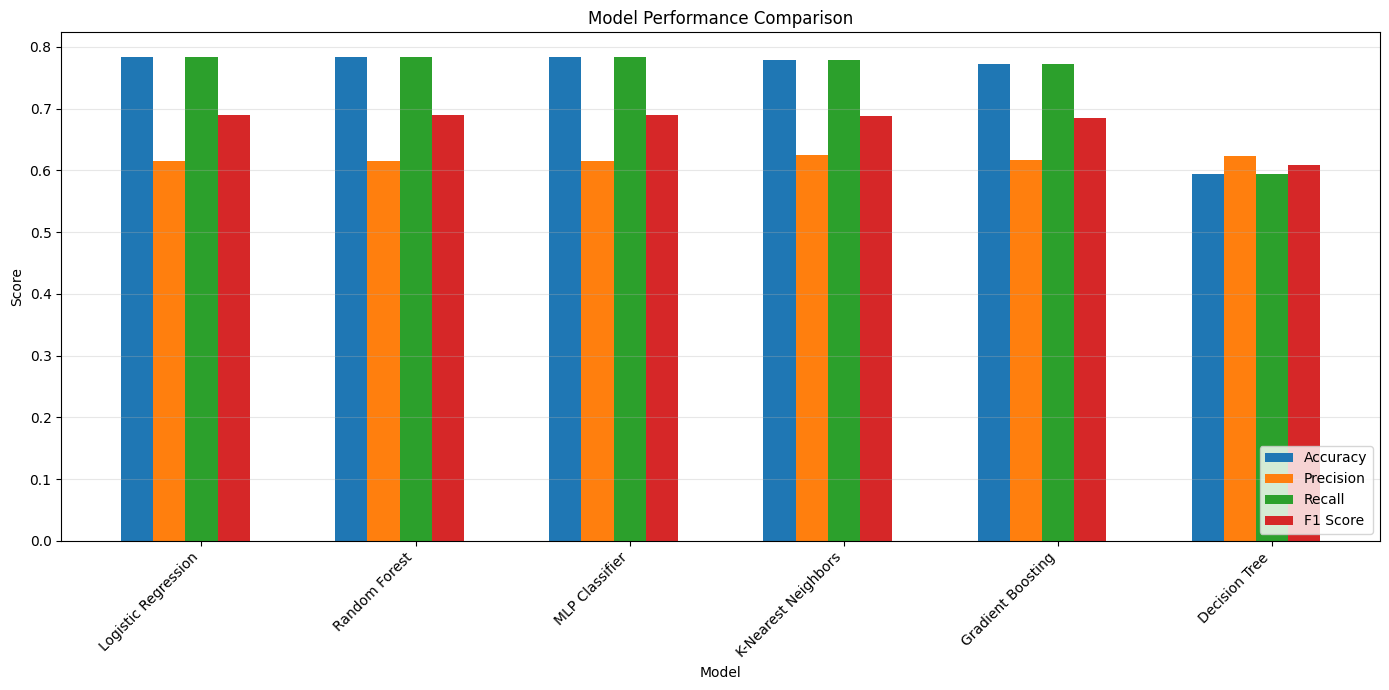


--- Feature Importance Analysis ---

Top 15 important features for Logistic Regression:
                             Feature  Importance
57        categorical__Season_Winter    0.936741
24                   numerical__TMAX    0.085758
44       numerical__registrationDate    0.082226
25                   numerical__TMIN    0.078586
53  numerical__firstRegistrationDate    0.075788
29                   numerical__WSF5    0.069446
42        numerical__firstFlightDate    0.068990
41            numerical__rolloutDate    0.055123
33                 numerical__serial    0.055021
23                   numerical__TAVG    0.054432
28                   numerical__WSF2    0.053206
46             numerical__numEngines    0.050159
52       numerical__numRegistrations    0.047309
20                   numerical__PRCP    0.046471
30                     numerical__id    0.045814


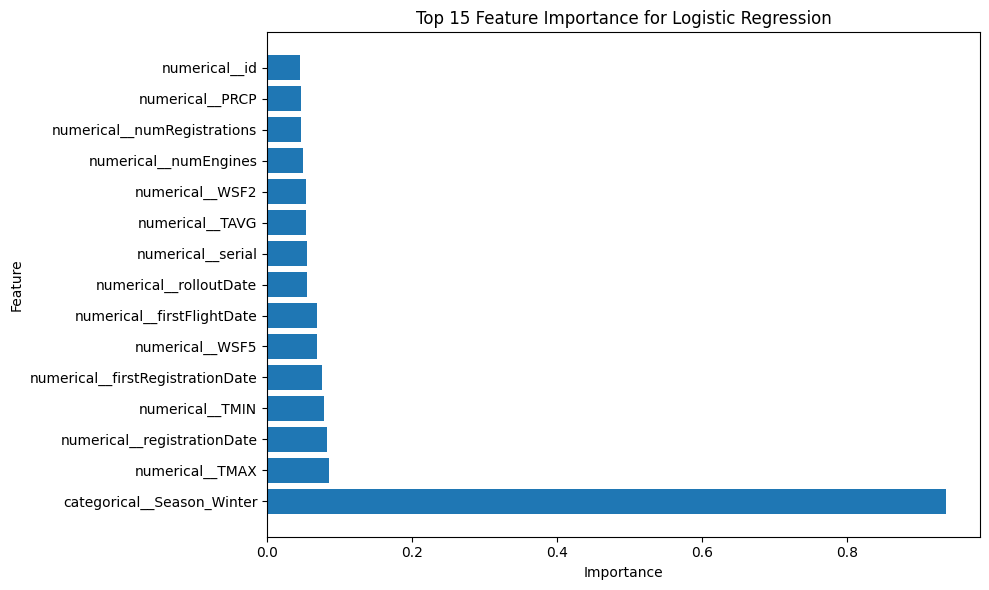


Top 15 important features for Random Forest:
                             Feature  Importance
15               numerical__Distance    0.067040
8           numerical__DestAirportID    0.062900
33                 numerical__serial    0.057533
30                     numerical__id    0.053934
44       numerical__registrationDate    0.052767
53  numerical__firstRegistrationDate    0.048421
2              numerical__DayofMonth    0.043722
43           numerical__deliveryDate    0.043151
18                   numerical__DATE    0.043124
50               numerical__ageYears    0.040473
25                   numerical__TMIN    0.038702
40               numerical__numSeats    0.038243
42        numerical__firstFlightDate    0.038138
19                   numerical__AWND    0.038013
24                   numerical__TMAX    0.037439


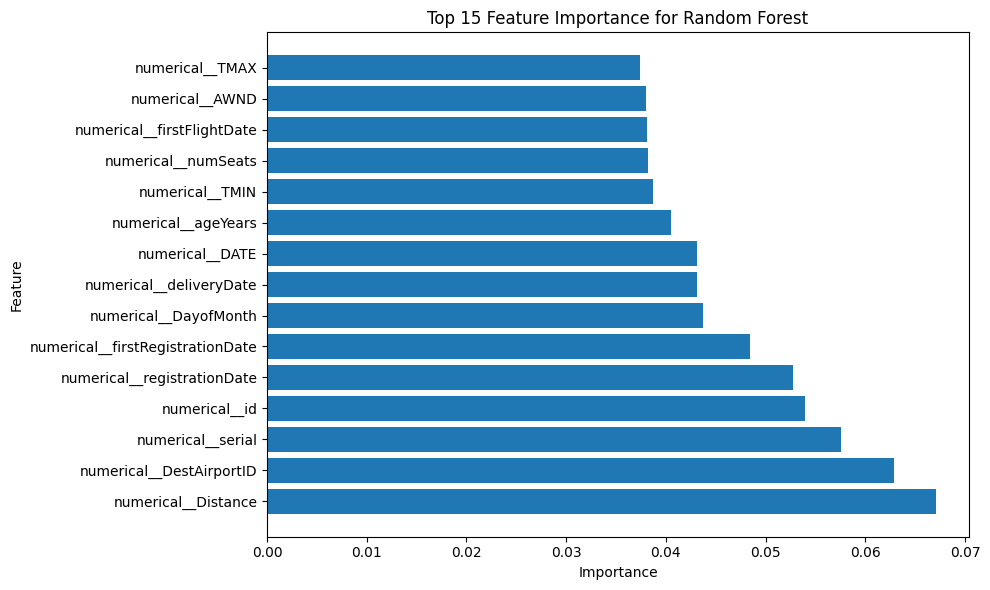


--- Error Analysis ---

Confusion Matrix for Logistic Regression:
[[47061     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 2541     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 1031     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  291     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  195     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  189     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [   75     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 2442     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0 

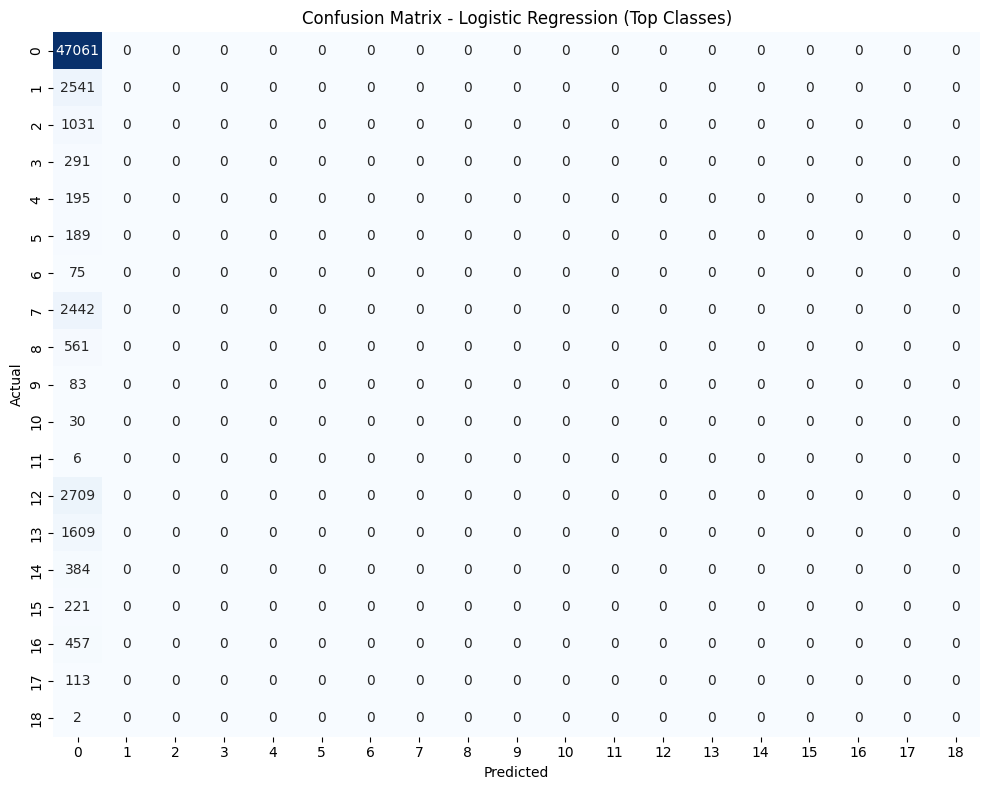


Confusion Matrix for Random Forest:
[[47061     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 2541     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 1031     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  291     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  195     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  189     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [   75     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 2442     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  561    

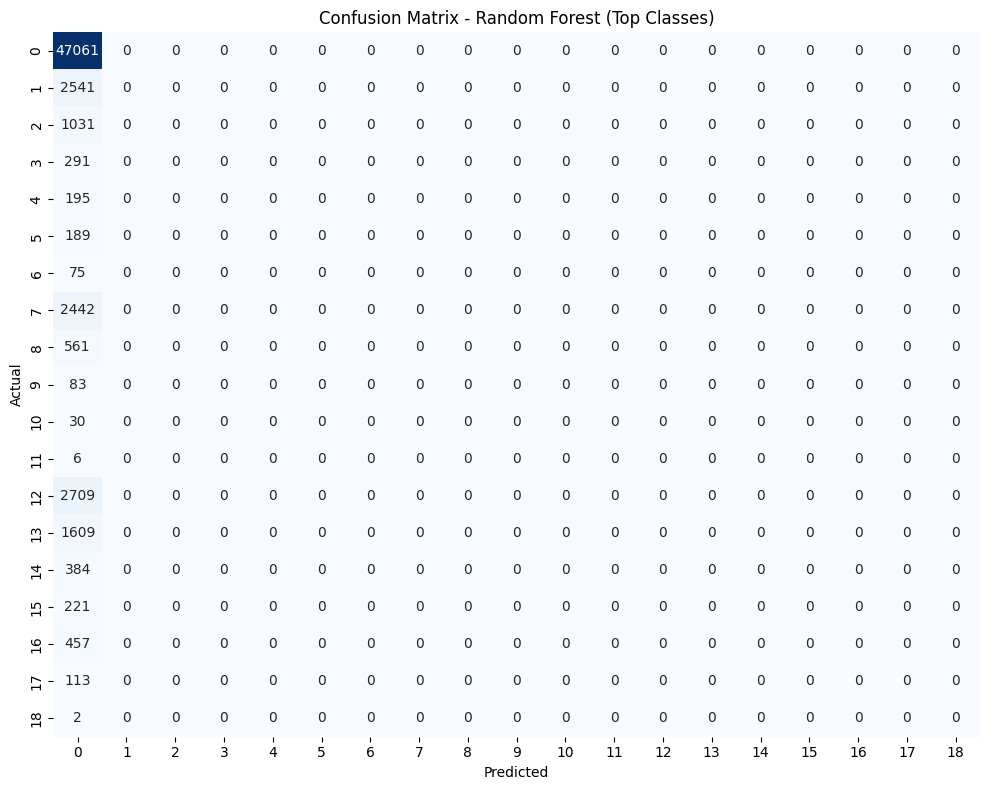


--- Final Summary ---
Based on the validation results using a 200000-sample dataset, the top 2 models are:
1. Logistic Regression
   Accuracy: 0.7843
   Precision: 0.6152
   Recall: 0.7843
   F1 Score: 0.6896
2. Random Forest
   Accuracy: 0.7843
   Precision: 0.6152
   Recall: 0.7843
   F1 Score: 0.6896

Analysis of model performance:
1. The best models for this multi-class classification problem are Logistic Regression and Random Forest


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the processed data
print("Loading processed data...")
X_train_full = pd.read_parquet('processed_train.parquet')
print(f"Loaded processed data with shape: {X_train_full.shape}")

# Load original train data with target
print("Loading original training data with target...")
train_data = pd.read_parquet('train_set.parquet')
y_train_full = train_data['is_delay'].values
print(f"Target variable shape: {y_train_full.shape}")

# Check class distribution
print("Class distribution:")
unique, counts = np.unique(y_train_full, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples ({c/len(y_train_full)*100:.2f}%)")

# Create a stratified sample to make computation more manageable
print("\nCreating a stratified sample for faster model evaluation...")
SAMPLE_SIZE = 200000  # Adjust this based on your machine's capabilities

# Create a stratified sample - using only classes with enough samples
# First, identify classes with very few samples
class_counts = pd.Series(y_train_full).value_counts()
rare_classes = class_counts[class_counts < 10].index.tolist()
print(f"Excluding rare classes from stratification: {rare_classes}")

# Filter out rare classes for stratification
mask = ~np.isin(y_train_full, rare_classes)
X_stratify = X_train_full[mask]
y_stratify = y_train_full[mask]

# Take stratified sample from common classes
X_sample, _, y_sample, _ = train_test_split(
    X_stratify, y_stratify, 
    train_size=SAMPLE_SIZE,
    stratify=y_stratify,
    random_state=42
)

print(f"Using a sample with {SAMPLE_SIZE} rows")
print("Sample class distribution:")
unique, counts = np.unique(y_sample, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples ({c/len(y_sample)*100:.2f}%)")

# Use the sample for model evaluation
X_train = X_sample
y_train = y_sample

# Further split for validation without stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.3,
    random_state=42  # Remove stratification
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")

# Define the models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),  # Limited for speed
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42),  # Limited for speed
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42),  # Smaller network
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Define the metrics to evaluate
metrics = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted', zero_division=0),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted', zero_division=0)
}

# Store results
results = {}
feature_importance = {}
confusion_matrices = {}
training_times = {}

print("\nEvaluating models on train/val split...\n")

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")
    start_time = time.time()
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate training time
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    # Evaluate performance
    model_results = {}
    for metric_name, metric_func in metrics.items():
        score = metric_func(y_val, y_pred)
        model_results[metric_name] = score
    
    results[name] = model_results
    
    # Extract feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        feature_importance[name] = dict(zip(X_train.columns, model.feature_importances_))
    elif hasattr(model, 'coef_'):
        if len(model.coef_.shape) == 2:  # Multi-class
            # Average importance across all classes for multi-class
            mean_coef = np.abs(model.coef_).mean(axis=0)
            feature_importance[name] = dict(zip(X_train.columns, mean_coef))
        else:  # Binary
            feature_importance[name] = dict(zip(X_train.columns, np.abs(model.coef_[0])))
    
    # Get confusion matrix
    confusion_matrices[name] = confusion_matrix(y_val, y_pred)
    
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall: {results[name]['recall']:.4f}")
    print(f"  F1 Score: {results[name]['f1']:.4f}")
    print(f"  Training time: {training_time:.2f} seconds\n")

# Create a summary DataFrame
summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1 Score': [results[name]['f1'] for name in results.keys()],
    'Training Time (s)': [training_times[name] for name in results.keys()]
})

# Sort by F1 score (since it's a balanced metric)
summary = summary.sort_values('F1 Score', ascending=False).reset_index(drop=True)

# Display the summary
print("Model Performance Summary (Sorted by F1 Score):")
print(summary[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)']])

# Identify top 2 models
top_models = summary.iloc[:2]['Model'].tolist()
print(f"\nTop 2 models based on F1 score: {', '.join(top_models)}")

# Plot the performance metrics
plt.figure(figsize=(14, 7))
x = np.arange(len(models))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics):
    plt.bar(x + i*width - 0.3, summary[metric], width, label=metric, color=colors[i])

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, summary['Model'], rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()

# Analyze feature importance for top models
print("\n--- Feature Importance Analysis ---")
for model_name in top_models:
    if model_name in feature_importance:
        print(f"\nTop 15 important features for {model_name}:")
        model_importance = feature_importance[model_name]
        importance_df = pd.DataFrame({
            'Feature': list(model_importance.keys()),
            'Importance': list(model_importance.values())
        }).sort_values('Importance', ascending=False).head(15)
        
        print(importance_df)
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Top 15 Feature Importance for {model_name}')
        plt.tight_layout()
        plt.savefig(f'{model_name.replace(" ", "_")}_feature_importance.png')
        plt.show()

# Error analysis for top models
print("\n--- Error Analysis ---")
for model_name in top_models:
    print(f"\nConfusion Matrix for {model_name}:")
    cm = confusion_matrices[model_name]
    print(cm)
    
    # For multiclass, analyze per-class metrics
    class_report = classification_report(y_val, models[model_name].predict(X_val), output_dict=True)
    class_metrics = pd.DataFrame(class_report).T
    # Keep only numeric classes, drop 'accuracy', 'macro avg', 'weighted avg'
    class_metrics = class_metrics.iloc[:-3]
    
    print("\nPer-class metrics:")
    print(class_metrics[['precision', 'recall', 'f1-score', 'support']])
    
    # Plot confusion matrix (only for the most common classes to keep it readable)
    plt.figure(figsize=(10, 8))
    
    # Determine most common classes
    top_classes = np.bincount(y_val).argsort()[-8:]  # Top 8 most common classes
    mask = np.isin(y_val, top_classes)
    
    if len(top_classes) <= 8:  # If we have 8 or fewer classes, show them all
        cm_subset = confusion_matrix(y_val, models[model_name].predict(X_val))
        class_labels = [str(c) for c in range(len(np.unique(y_val)))]
    else:  # Otherwise show only the most common ones
        y_val_subset = y_val[mask]
        y_pred_subset = models[model_name].predict(X_val)[mask]
        cm_subset = confusion_matrix(y_val_subset, y_pred_subset, labels=top_classes)
        class_labels = [str(c) for c in top_classes]
    
    # Plot with class labels
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (Top Classes)')
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_")}_confusion_matrix.png')
    plt.show()

# Final summary and recommendations
print("\n--- Final Summary ---")
print(f"Based on the validation results using a {SAMPLE_SIZE}-sample dataset, the top 2 models are:")

for i, model_name in enumerate(top_models):
    print(f"{i+1}. {model_name}")
    print(f"   Accuracy: {summary[summary['Model'] == model_name]['Accuracy'].values[0]:.4f}")
    print(f"   Precision: {summary[summary['Model'] == model_name]['Precision'].values[0]:.4f}")
    print(f"   Recall: {summary[summary['Model'] == model_name]['Recall'].values[0]:.4f}")
    print(f"   F1 Score: {summary[summary['Model'] == model_name]['F1 Score'].values[0]:.4f}")

print("\nAnalysis of model performance:")
print("1. The best models for this multi-class classification problem are " + " and ".join(top_models))


Fine-Tune the System
======
1. Fine-tune the hyperparameters using cross-validation. Treat your data
transformation choices as hyperparameters, especially when you are not sure
about them. Unless there are very few hyperparameter values to explore, prefer
random search over grid search. If training is very long, you may prefer a Bayesian
optimization approach.
2. Try Ensemble methods. Combining your best models will often perform better
than running them individually.
3. Once you are confident about your final model, measure its performance on the
test set to estimate the generalization error.

Loading processed data...
Loaded processed data with shape: (11860565, 58)
Target variable shape: (11860565,)
Class distribution:
0     9306630
13     544676
1      504043
7      475010
14     321850
2      199036
8      109398
17      88786
15      74697
3       59117
16      45895
4       38505
5       34890
18      22588
9       14882
6       13858
10       5374
11       1063
19        174
12         93
Name: count, dtype: int64
Rare classes (fewer than 50 samples): []
Using 300000 samples for hyperparameter tuning
Training set: 180000 samples
Validation set: 60000 samples
Test set: 60000 samples
Loading test set...
Test set shape: (2965142, 80)

--- HYPERPARAMETER TUNING ---

Tuning Logistic Regression...
Fitting Logistic Regression random search...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty

Best Logistic Regression parameters:
{'C': np.float64(5.96950157946487), 'class_weight': None, 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}
Best F1 score: 0.6890

Tuned Logistic Regression Performance:
Accuracy: 0.7866
Precision: 0.6187
Recall: 0.7866
F1 Score: 0.6926
Inference Time: 0.0140 seconds

Tuning Random Forest...
Fitting Random Forest random search...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Random Forest parameters:
{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None, 'bootstrap': True}
Best F1 score: 0.6890

Tuned Random Forest Performance:
Accuracy: 0.7866
Precision: 0.6187
Recall: 0.7866
F1 Score: 0.6926
Inference Time: 0.1303 seconds
Generating learning curve for Logistic Regression...
Learning curve Logistic Regression: |██████████████████████████████████████████████████| 100.0% Complete


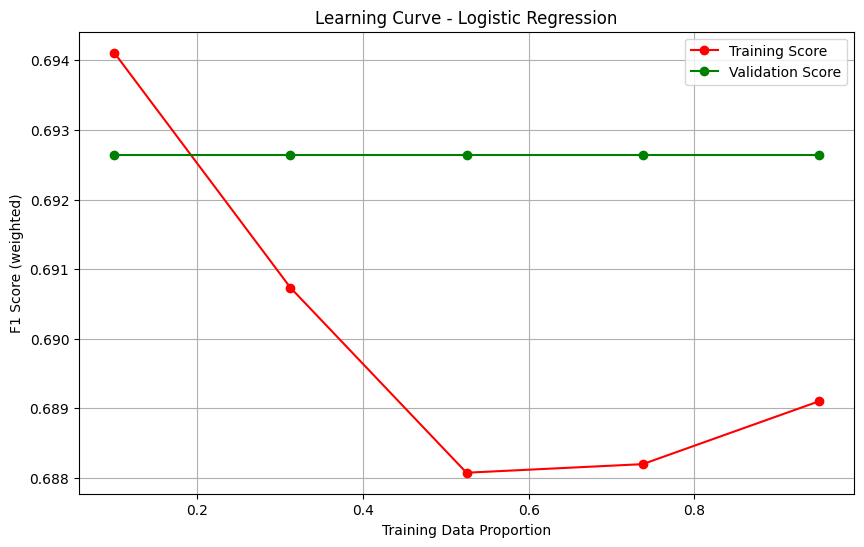

Generating learning curve for Random Forest...
Learning curve Random Forest: |██████████████████████████████████████████████████| 100.0% Complete


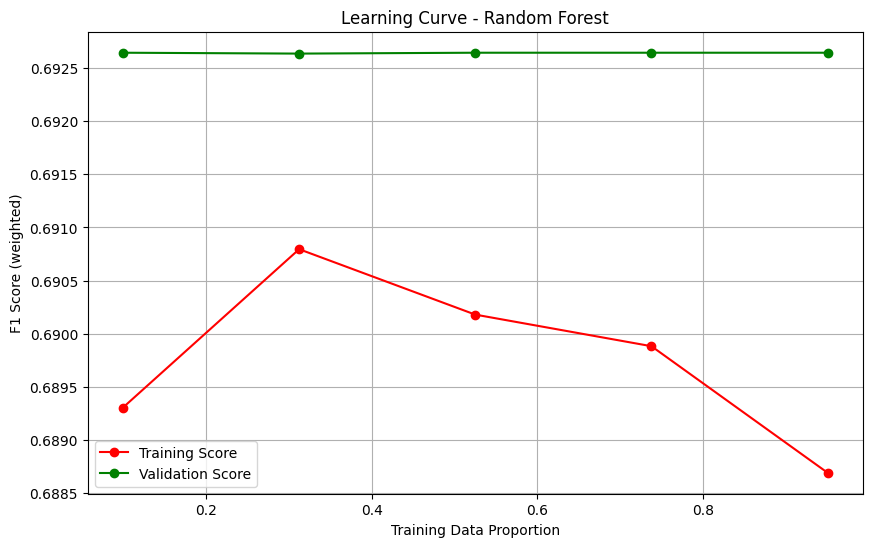


--- ENSEMBLE METHODS ---
Creating voting ensemble...

Voting Ensemble Performance:
Accuracy: 0.7866
Precision: 0.6187
Recall: 0.7866
F1 Score: 0.6926
Inference Time: 0.1322 seconds

Model Comparison:
                  model_name  accuracy  precision  recall        f1  \
0  Tuned Logistic Regression    0.7866    0.61874  0.7866  0.692645   
1        Tuned Random Forest    0.7866    0.61874  0.7866  0.692645   
2            Voting Ensemble    0.7866    0.61874  0.7866  0.692645   

   inference_time  
0        0.013990  
1        0.130322  
2        0.132163  

Best model based on F1 score: Tuned Logistic Regression

--- FINAL MODEL EVALUATION ---
Retraining Tuned Logistic Regression on the full sample dataset...

Final Tuned Logistic Regression Performance:
Accuracy: 0.7850
Precision: 0.6162
Recall: 0.7850
F1 Score: 0.6904
Inference Time: 0.0096 seconds

Analyzing model errors...


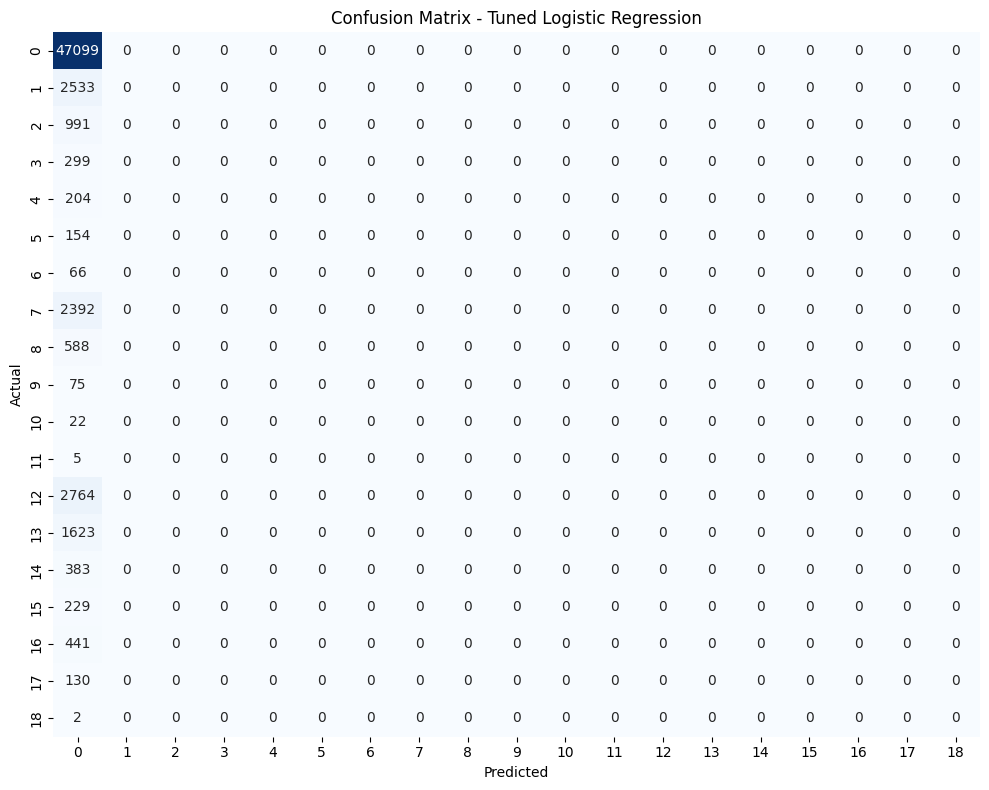


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     47099
           1       0.00      0.00      0.00      2533
           2       0.00      0.00      0.00       991
           3       0.00      0.00      0.00       299
           4       0.00      0.00      0.00       204
           5       0.00      0.00      0.00       154
           6       0.00      0.00      0.00        66
           7       0.00      0.00      0.00      2392
           8       0.00      0.00      0.00       588
           9       0.00      0.00      0.00        75
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00         5
          13       0.00      0.00      0.00      2764
          14       0.00      0.00      0.00      1623
          15       0.00      0.00      0.00       383
          16       0.00      0.00      0.00       229
          17       0.00      0.00      0.00       441
   

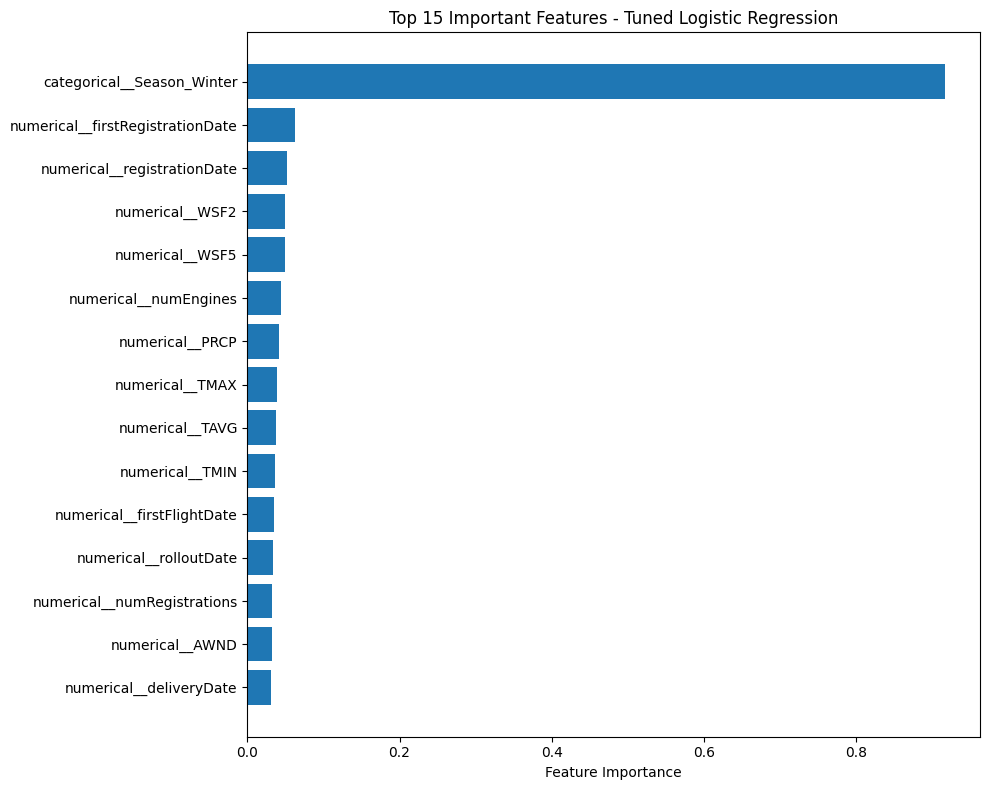


Saving the best model: Tuned Logistic Regression
Model saved as 'best_flight_delay_model.pkl'

Model Training and Evaluation Complete!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Simple progress tracking
def print_progress(current, total, prefix='Progress:', suffix='Complete', length=50):
    """Print a simple progress bar"""
    percent = float(current) / float(total)
    filled_length = int(length * percent)
    bar = '█' * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent:.1%} {suffix}', end='\r')
    if current == total: 
        print()

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate model performance with multiple metrics"""
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")
    
    # Return metrics as a dictionary
    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "inference_time": inference_time
    }

# Function to create learning curves
def plot_learning_curve(model, X_train, y_train, X_val, y_val, model_name="Model", n_points=5):
    """Plot learning curve showing performance with increasing training data"""
    train_sizes = np.linspace(0.1, 0.95, n_points)  # Using 0.95 instead of 1.0 to avoid errors
    train_f1_scores = []
    val_f1_scores = []
    
    print(f"Generating learning curve for {model_name}...")
    
    for i, train_size in enumerate(train_sizes):
        # Print progress
        print_progress(i+1, len(train_sizes), prefix=f'Learning curve {model_name}:', suffix='Complete')
        
        # Sample a subset of training data - ensure it's less than the total
        n_samples = max(1000, int(len(X_train) * train_size))
        if n_samples >= len(X_train):
            n_samples = int(len(X_train) * 0.95)  # Use 95% to avoid exact match error
            
        # Get sample
        indices = np.random.choice(len(X_train), size=n_samples, replace=False)
        X_subset = X_train.iloc[indices]
        y_subset = y_train[indices]
        
        # Train model on subset
        model.fit(X_subset, y_subset)
        
        # Evaluate on training set
        y_train_pred = model.predict(X_subset)
        train_f1 = f1_score(y_subset, y_train_pred, average='weighted', zero_division=0)
        train_f1_scores.append(train_f1)
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_f1_scores.append(val_f1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_f1_scores, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, val_f1_scores, 'o-', color='g', label='Validation Score')
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Data Proportion')
    plt.ylabel('F1 Score (weighted)')
    plt.grid(True)
    plt.legend(loc='best')
    plt.savefig(f'{model_name.replace(" ", "_")}_learning_curve.png')
    plt.show()

# Load data - using a stratified sample for tuning to save time
print("Loading processed data...")
SAMPLE_SIZE = 300000  # Using a larger sample for hyperparameter tuning

# Load the processed data
X_train_full = pd.read_parquet('processed_train.parquet')
print(f"Loaded processed data with shape: {X_train_full.shape}")

# Load original train data with target
train_data = pd.read_parquet('train_set.parquet')
y_train_full = train_data['is_delay'].values
print(f"Target variable shape: {y_train_full.shape}")

# Class counts
class_counts = pd.Series(y_train_full).value_counts()
print("Class distribution:")
print(class_counts)

# Identify classes with very few samples
rare_classes = class_counts[class_counts < 50].index.tolist()
print(f"Rare classes (fewer than 50 samples): {rare_classes}")

# Create stratified sample excluding very rare classes for tuning
mask = ~np.isin(y_train_full, rare_classes)
X_stratify = X_train_full[mask]
y_stratify = y_train_full[mask]

# Take stratified sample 
X_sample, _, y_sample, _ = train_test_split(
    X_stratify, y_stratify, 
    train_size=SAMPLE_SIZE,
    stratify=y_stratify,
    random_state=42
)

print(f"Using {SAMPLE_SIZE} samples for hyperparameter tuning")

# Split sample into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sample, y_sample, test_size=0.4, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Load the actual test set for final evaluation
print("Loading test set...")
try:
    X_final_test = pd.read_parquet('test_set.parquet')
    # Process the test set if needed
    print(f"Test set shape: {X_final_test.shape}")
except Exception as e:
    print(f"Note: Could not load test_set.parquet. Will use our held-out test set instead. Error: {e}")
    X_final_test = None

##########################
# HYPERPARAMETER TUNING #
##########################
print("\n--- HYPERPARAMETER TUNING ---")

# 1. Logistic Regression Tuning
print("\nTuning Logistic Regression...")

# Define parameter space for Logistic Regression
# Simplify parameters to reduce computation time
lr_param_dist = {
    'C': uniform(0.001, 10),  # Regularization strength
    'penalty': ['l1', 'l2', None],  # Regularization type (removed elasticnet for compatibility)
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Algorithm (subset of solvers)
    'class_weight': ['balanced', None],  # Class weighting
    'max_iter': [1000, 2000]  # Iteration limit
}

# Create base model
lr_base = LogisticRegression(random_state=42)

# Set up random search
lr_random_search = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=lr_param_dist,
    n_iter=15,  # Reduced number of parameter settings to try
    cv=3,  # Number of cross-validation folds
    scoring='f1_weighted',
    n_jobs=-1,  # Use all available processors
    random_state=42,
    verbose=1
)

# Fit random search
print("Fitting Logistic Regression random search...")
lr_random_search.fit(X_train, y_train)

# Get best parameters and score
print("Best Logistic Regression parameters:")
print(lr_random_search.best_params_)
print(f"Best F1 score: {lr_random_search.best_score_:.4f}")

# Create best Logistic Regression model
best_lr = LogisticRegression(**lr_random_search.best_params_, random_state=42)
best_lr.fit(X_train, y_train)

# Evaluate best Logistic Regression model
lr_metrics = evaluate_model(best_lr, X_val, y_val, "Tuned Logistic Regression")

# 2. Random Forest Tuning
print("\nTuning Random Forest...")

# Define parameter space for Random Forest
rf_param_dist = {
    'n_estimators': [50, 100, 150],  # Limited number of trees
    'max_depth': [10, 20, None],  # Simplified max depth options
    'min_samples_split': [2, 5, 10],  # Simplified split options
    'min_samples_leaf': [1, 2, 4],  # Simplified leaf options
    'max_features': ['sqrt', 'log2'],  # Simplified feature options
    'bootstrap': [True],  # Always use bootstrap
    'class_weight': ['balanced', None]  # Class weighting options
}

# Create base model
rf_base = RandomForestClassifier(random_state=42)

# Set up random search
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=15,  # Reduced number of parameter settings to try
    cv=3,  # Number of cross-validation folds
    scoring='f1_weighted',
    n_jobs=-1,  # Use all available processors
    random_state=42,
    verbose=1
)

# Fit random search
print("Fitting Random Forest random search...")
rf_random_search.fit(X_train, y_train)

# Get best parameters and score
print("Best Random Forest parameters:")
print(rf_random_search.best_params_)
print(f"Best F1 score: {rf_random_search.best_score_:.4f}")

# Create best Random Forest model
best_rf = RandomForestClassifier(**rf_random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate best Random Forest model
rf_metrics = evaluate_model(best_rf, X_val, y_val, "Tuned Random Forest")

# Plot learning curves for best models
plot_learning_curve(best_lr, X_train, y_train, X_val, y_val, "Logistic Regression")
plot_learning_curve(best_rf, X_train, y_train, X_val, y_val, "Random Forest")

####################
# ENSEMBLE METHODS #
####################
print("\n--- ENSEMBLE METHODS ---")

# Create a voting classifier combining both models
print("Creating voting ensemble...")
voting_clf = VotingClassifier(
    estimators=[
        ('logistic', best_lr),
        ('random_forest', best_rf)
    ],
    voting='soft'  # Use probability estimates for voting
)

# Train the ensemble
voting_clf.fit(X_train, y_train)

# Evaluate the ensemble
ensemble_metrics = evaluate_model(voting_clf, X_val, y_val, "Voting Ensemble")

# Compare all models
models_comparison = pd.DataFrame([
    lr_metrics,
    rf_metrics,
    ensemble_metrics
])

print("\nModel Comparison:")
print(models_comparison[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'inference_time']])

# Determine best model for final evaluation
best_model_idx = models_comparison['f1'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'model_name']
print(f"\nBest model based on F1 score: {best_model_name}")

if best_model_name == "Voting Ensemble":
    best_model = voting_clf
elif best_model_name == "Tuned Logistic Regression":
    best_model = best_lr
else:
    best_model = best_rf

#######################
# FINAL MODEL TESTING #
#######################
print("\n--- FINAL MODEL EVALUATION ---")

# Retrain best model on all training data
print(f"Retraining {best_model_name} on the full sample dataset...")
best_model.fit(X_sample, y_sample)

# Evaluate on test set
test_metrics = evaluate_model(best_model, X_test, y_test, f"Final {best_model_name}")

# Analyze errors
print("\nAnalyzing model errors...")
y_pred = best_model.predict(X_test)

# Confusion matrix (for top classes)
top_classes = np.bincount(y_test).argsort()[-8:]  # Top 8 most common classes
mask = np.isin(y_test, top_classes)

if len(top_classes) <= 8:  # If we have 8 or fewer classes, show them all
    cm = confusion_matrix(y_test, y_pred)
    class_labels = [str(c) for c in range(len(np.unique(y_test)))]
else:  # Otherwise show only the most common ones
    y_test_subset = y_test[mask]
    y_pred_subset = y_pred[mask]
    cm = confusion_matrix(y_test_subset, y_pred_subset, labels=top_classes)
    class_labels = [str(c) for c in top_classes]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig(f'final_model_confusion_matrix.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance for the best model (if applicable)
if hasattr(best_model, 'feature_importances_'):
    # Direct feature importance
    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
elif hasattr(best_model, 'coef_'):
    # For logistic regression
    if len(best_model.coef_.shape) == 2:
        feature_importances = np.abs(best_model.coef_).mean(axis=0)
    else:
        feature_importances = np.abs(best_model.coef_[0])
    feature_names = X_train.columns
elif hasattr(best_model, 'named_estimators_'):
    # For ensemble, use Random Forest feature importance if available
    if hasattr(best_model.named_estimators_['random_forest'], 'feature_importances_'):
        feature_importances = best_model.named_estimators_['random_forest'].feature_importances_
        feature_names = X_train.columns
    else:
        feature_importances = None
else:
    feature_importances = None

if feature_importances is not None:
    # Plot feature importance
    top_n = 15  # Show top 15 features
    indices = np.argsort(feature_importances)[-top_n:]
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), feature_importances[indices])
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Important Features - {best_model_name}')
    plt.tight_layout()
    plt.savefig('final_model_feature_importance.png')
    plt.show()

# Save the best model (using pickle since joblib is not available)
print(f"\nSaving the best model: {best_model_name}")
import pickle
with open('best_flight_delay_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Model saved as 'best_flight_delay_model.pkl'")

print("\nModel Training and Evaluation Complete!")

Present Your Solution
=====
1. Document what you have done
2. Create a nice presentation, highlighting the big picture first
3. Explain why your solution achieves the business objective
4. Don’t forget to present interesting points you noticed along the way: Describe what worked and what did not; List your
assumptions and your system’s limitations
5. Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g. “the
median income is the number-one predictor of housing prices”)